<h1 style="text-align:center">Personalized Cancer Diagnosis</h1>

# Description
Classify the given genetic mutation by using given clinical text data and variance at that specific gene.

## Data Description
- Source: [Kaggle](https://www.kaggle.com/c/msk-redefining-cancer-treatment/)
- Donated by: Memorial Sloan Kettering Cancer Center (MSKCC)


- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID

- Data file's information:
    * training_variants (ID , Gene, Variations, Class)
    * training_text (ID, Text)
    
    
- There are 9 different types of genetic mutations.

## Objectives
* Error cost is very high.
* Interpretability is required.
* Probability of a data-point belonging to each class is needed.
* No low-latency requirement.

## Metric(s): 
* Multi class log-loss 
* Confusion matrix 

# Exploratory Data Analysis

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.ncols = 100

In [2]:
# reading gene and variation data
data1 = pd.read_csv("Data/training_variants")
print('Number of data points : ', data1.shape[0])
print('Number of features : ', data1.shape[1])
print('Features : ', data1.columns.values)
data1.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<p>
    training/training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

In [3]:
# reading text data
data2 =pd.read_csv("Data/training_text",sep="\|\|",engine="python",
                       names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data2.shape[0])
print('Number of features : ', data2.shape[1])
print('Features : ', data2.columns.values)
data2.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [4]:
# Combining data by ID
data = pd.merge(data1, data2, on='ID', how='left')
data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


## Preprocessing Text
- Removed stop words.
- Removed special characters.

In [5]:
from nltk.corpus import stopwords
import re

stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data[column][index] = string

In [6]:
#text processing stage.
for index, row in tqdm(data.iterrows(), ncols=100):
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)

1115it [00:55, 19.76it/s]

there is no text description for id: 1109


1280it [01:03, 21.23it/s]

there is no text description for id: 1277


1415it [01:09, 22.34it/s]

there is no text description for id: 1407


1646it [01:21, 21.26it/s]

there is no text description for id: 1639


2760it [02:15, 18.97it/s]

there is no text description for id: 2755


3321it [02:42, 24.90it/s]


In [7]:
data[data.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [8]:
data = data.dropna(axis=0)

## Splitting Data
- Splitting data into train, test and cross validation (64:20:16)

In [9]:
from sklearn.model_selection import train_test_split

y_true = data['Class'].values
data.Gene      = data.Gene.str.replace('\s+', '_')
data.Variation = data.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same -
# distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_x, Y_train, test_y = train_test_split(data, 
                                                     y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by -
# maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_x, cv_x, train_y, cv_y = train_test_split(X_train, 
                                                  Y_train, stratify=Y_train, test_size=0.2)

In [10]:
print('Number of data points in train data:', train_x.shape[0])
print('Number of data points in test data:', test_x.shape[0])
print('Number of data points in cross validation data:', cv_x.shape[0])

Number of data points in train data: 2121
Number of data points in test data: 664
Number of data points in cross validation data: 531


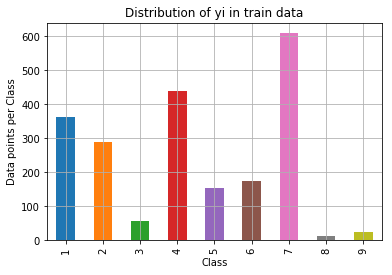

Number of data points in class 7 : 609 ( 28.713 %)
Number of data points in class 4 : 439 ( 20.698 %)
Number of data points in class 1 : 362 ( 17.067 %)
Number of data points in class 2 : 289 ( 13.626 %)
Number of data points in class 6 : 174 ( 8.204 %)
Number of data points in class 5 : 155 ( 7.308 %)
Number of data points in class 3 : 57 ( 2.687 %)
Number of data points in class 9 : 24 ( 1.132 %)
Number of data points in class 8 : 12 ( 0.566 %)
--------------------------------------------------------------------------------


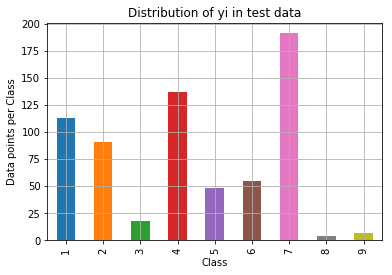

Number of data points in class 7 : 191 ( 28.765 %)
Number of data points in class 4 : 137 ( 20.633 %)
Number of data points in class 1 : 113 ( 17.018 %)
Number of data points in class 2 : 91 ( 13.705 %)
Number of data points in class 6 : 55 ( 8.283 %)
Number of data points in class 5 : 48 ( 7.229 %)
Number of data points in class 3 : 18 ( 2.711 %)
Number of data points in class 9 : 7 ( 1.054 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


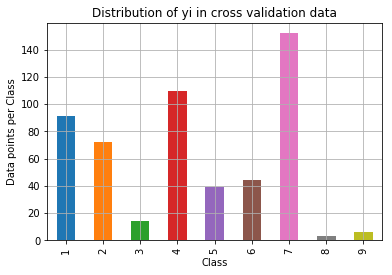

Number of data points in class 7 : 152 ( 28.625 %)
Number of data points in class 4 : 110 ( 20.716 %)
Number of data points in class 1 : 91 ( 17.137 %)
Number of data points in class 2 : 72 ( 13.559 %)
Number of data points in class 6 : 44 ( 8.286 %)
Number of data points in class 5 : 39 ( 7.345 %)
Number of data points in class 3 : 14 ( 2.637 %)
Number of data points in class 9 : 6 ( 1.13 %)
Number of data points in class 8 : 3 ( 0.565 %)


In [11]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_x['Class'].value_counts().sortlevel()
test_class_distribution = test_x['Class'].value_counts().sortlevel()
cv_class_distribution = cv_x['Class'].value_counts().sortlevel()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',
          train_class_distribution.values[i], '(', 
            np.round((train_class_distribution.values[i]/train_x.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',
          test_class_distribution.values[i], '(', 
          np.round((test_class_distribution.values[i]/test_x.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',
          cv_class_distribution.values[i], '(', 
          np.round((cv_class_distribution.values[i]/cv_x.shape[0]*100), 3), '%)')

In [12]:
from sklearn.metrics import confusion_matrix

# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds -
    # to rows in two diamensionalarray
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows -
    # in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.5141305002096295
Log loss on Test Data using Random Model 2.5121583214081955
-------------------- Confusion matrix --------------------


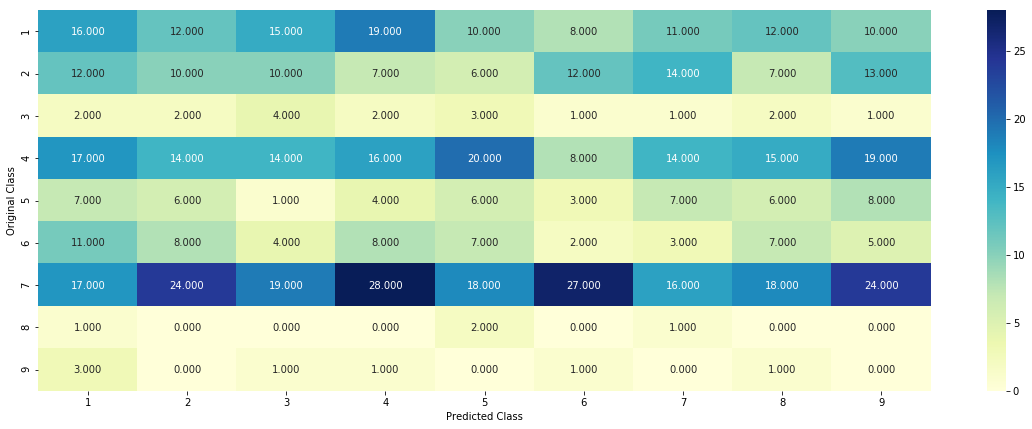

-------------------- Precision matrix (Columm Sum=1) --------------------


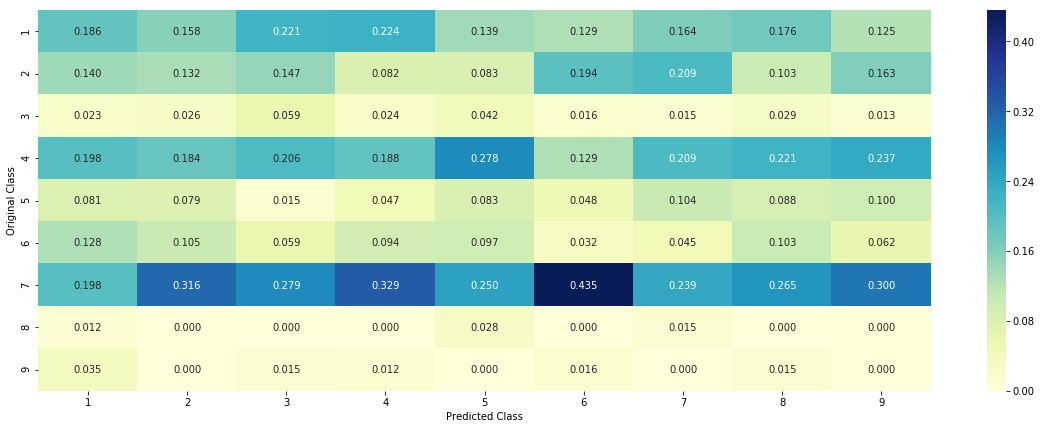

-------------------- Recall matrix (Row sum=1) --------------------


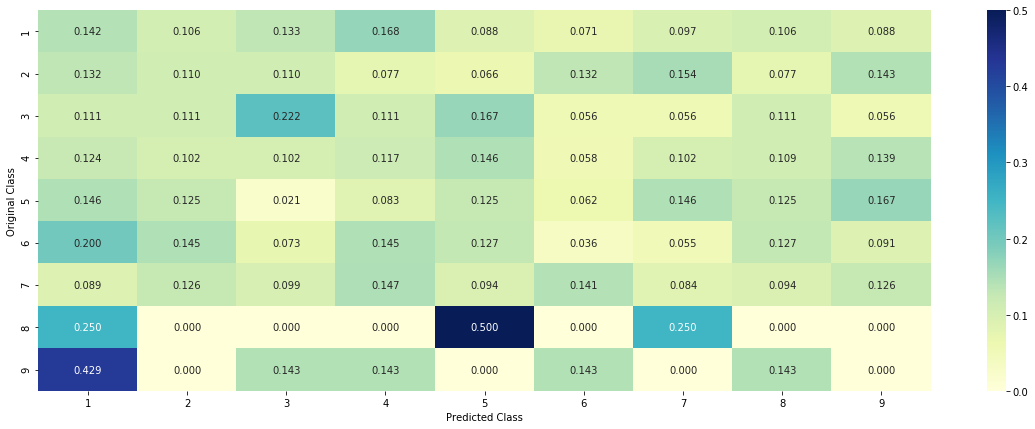

In [13]:
from sklearn.metrics import log_loss

# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = test_x.shape[0]
cv_data_len = cv_x.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(cv_y,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(test_y,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(test_y, predicted_y+1)

## Featurization

In [14]:
# code for response coding with Laplace smoothing.
def get_gv_fea_dict(alpha, feature, df):
    value_count = train_x[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_x.loc[(train_x['Class']==k) & (train_x[feature]==i)]
            
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_x[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

### featurize: Gene feature

- There are two ways we can factorize gene feature.
    * One hot encoding
    * Response coding

In [15]:
# one hot encoding 
from sklearn.feature_extraction.text import CountVectorizer
gene_vectorizer = CountVectorizer()
one_hot_geneTrain = gene_vectorizer.fit_transform(train_x['Gene'])
one_hot_geneCv = gene_vectorizer.transform(cv_x['Gene'])
one_hot_geneTest = gene_vectorizer.transform(test_x['Gene'])

In [16]:
print("Structure of one hot gene feature data: ")
print("Shape of one hot train gene data: ", one_hot_geneTrain.shape)
print("Shape of one hot cv gene data: ", one_hot_geneCv.shape)
print("Shape of one hot test gene data: ", one_hot_geneTest.shape)

Structure of one hot gene feature data: 
Shape of one hot train gene data:  (2121, 231)
Shape of one hot cv gene data:  (531, 231)
Shape of one hot test gene data:  (664, 231)


In [17]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
responseCoding_geneTrain = np.array(get_gv_feature(alpha, "Gene", train_x))
responseCoding_geneCv = np.array(get_gv_feature(alpha, "Gene", cv_x)) 
responseCoding_geneTest = np.array(get_gv_feature(alpha, "Gene", test_x))

In [18]:
print("Structure of response coding gene feature data: ")
print("Shape of response coding train gene data: ", responseCoding_geneTrain.shape)
print("Shape of response coding cv gene data: ", responseCoding_geneCv.shape)
print("Shape of response coding test gene data: ", responseCoding_geneTest.shape)

Structure of response coding gene feature data: 
Shape of response coding train gene data:  (2121, 9)
Shape of response coding cv gene data:  (531, 9)
Shape of response coding test gene data:  (664, 9)


### featurize: variation feature

- There are two ways we can factorize gene feature.
    * One hot encoding
    * Response coding

In [19]:
# one hot encoding 
from sklearn.feature_extraction.text import CountVectorizer
variation_vectorizer = CountVectorizer()
one_hot_variationTrain = gene_vectorizer.fit_transform(train_x['Variation'])
one_hot_variationCv = gene_vectorizer.transform(cv_x['Variation'])
one_hot_variationTest = gene_vectorizer.transform(test_x['Variation'])

In [20]:
print("Structure of one hot variation feature data: ")
print("Shape of one hot train variation data: ", one_hot_variationTrain.shape)
print("Shape of one hot cv variation data: ", one_hot_variationCv.shape)
print("Shape of one hot test variation data: ", one_hot_variationTest.shape)

Structure of one hot variation feature data: 
Shape of one hot train variation data:  (2121, 1964)
Shape of one hot cv variation data:  (531, 1964)
Shape of one hot test variation data:  (664, 1964)


In [21]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
responseCoding_variationTrain = np.array(get_gv_feature(alpha, "Variation", train_x))
responseCoding_variationCv = np.array(get_gv_feature(alpha, "Variation", cv_x)) 
responseCoding_variationTest = np.array(get_gv_feature(alpha, "Variation", test_x))

In [22]:
print("Structure of response coding variation feature data: ")
print("Shape of response coding train variation data: ", responseCoding_variationTrain.shape)
print("Shape of response coding cv variation data: ", responseCoding_variationCv.shape)
print("Shape of response coding test variation data: ", responseCoding_variationTest.shape)

Structure of response coding variation feature data: 
Shape of response coding train variation data:  (2121, 9)
Shape of response coding cv variation data:  (531, 9)
Shape of response coding test variation data:  (664, 9)


#  Bag of Words 

## Featurize: Text
* Building countvectorizer by taking max 1500 feature.

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

bow_model = CountVectorizer(max_features=1500)
bow_Train = bow_model.fit_transform(train_x['TEXT'])
bow_Cv = bow_model.fit_transform(cv_x['TEXT'])
bow_Test = bow_model.fit_transform(test_x['TEXT'])

In [24]:
print("Structure of Text data: ")
print("Shape of bow train text: ", bow_Train.shape)
print("Shape of bow cv text: ", bow_Cv.shape)
print("Shape of bow test text: ", bow_Test.shape)

Structure of Text data: 
Shape of bow train text:  (2121, 1500)
Shape of bow cv text:  (531, 1500)
Shape of bow test text:  (664, 1500)


## Stacking features

In [25]:
from scipy.sparse import hstack

one_hot_Train = hstack((one_hot_geneTrain, one_hot_variationTrain, bow_Train))
one_hot_Cv = hstack((one_hot_geneCv, one_hot_variationCv, bow_Cv))
one_hot_Test = hstack((one_hot_geneTest, one_hot_variationTest, bow_Test))

In [26]:
print("Structure of Total one hot data: ")
print("Shape of one hot train data: ", one_hot_Train.shape)
print("Shape of one hot cv data: ", one_hot_Cv.shape)
print("Shape of one hot test data: ", one_hot_Test.shape)

Structure of Total one hot data: 
Shape of one hot train data:  (2121, 3695)
Shape of one hot cv data:  (531, 3695)
Shape of one hot test data:  (664, 3695)


In [27]:
from scipy.sparse import hstack

responseCoding_Train = hstack((responseCoding_geneTrain, responseCoding_variationTrain, bow_Train))
responseCoding_Cv = hstack((responseCoding_geneCv, responseCoding_variationCv, bow_Cv))
responseCoding_Test = hstack((responseCoding_geneTest, responseCoding_variationTest, bow_Test))

In [28]:
print("Structure of Total one hot data: ")
print("Shape of one hot train data: ", responseCoding_Train.shape)
print("Shape of one hot cv data: ", responseCoding_Cv.shape)
print("Shape of one hot test data: ", responseCoding_Test.shape)

Structure of Total one hot data: 
Shape of one hot train data:  (2121, 1518)
Shape of one hot cv data:  (531, 1518)
Shape of one hot test data:  (664, 1518)


# Machine Learning Models

## Naive Bayes

### Training on one hot data and with no class balancing

for alpha = 1e-05
Log Loss : 1.7450982725236863
for alpha = 0.0001
Log Loss : 1.745151279820324
for alpha = 0.001
Log Loss : 1.7386066672963931
for alpha = 0.1
Log Loss : 1.7499637271612136
for alpha = 1
Log Loss : 1.7674163593485201
for alpha = 10
Log Loss : 1.7399598890950467
for alpha = 100
Log Loss : 1.7533829083073122
for alpha = 1000
Log Loss : 1.827822611326176


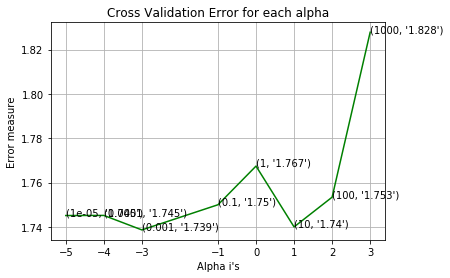

For values of best alpha =  0.001 The train log loss is: 1.308453920901874
For values of best alpha =  0.001 The cross validation log loss is: 1.7386066672963931
For values of best alpha =  0.001 The test log loss is: 1.7799173706125093
For values of best alpha =  0.001 The ratio of misclassified is: 64.7590361445783


In [29]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence = []
performence.append(["Naive Bayes", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on response coding data and with no class balancing

for alpha = 1e-05
Log Loss : 1.7524620080376867
for alpha = 0.0001
Log Loss : 1.7550508737457664
for alpha = 0.001
Log Loss : 1.7482312790367742
for alpha = 0.1
Log Loss : 1.7577022290689575
for alpha = 1
Log Loss : 1.7716673988592633
for alpha = 10
Log Loss : 1.798173288846481
for alpha = 100
Log Loss : 1.7690779094212914
for alpha = 1000
Log Loss : 2.207559568060874


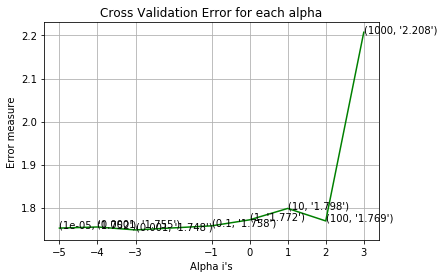

For values of best alpha =  0.001 The train log loss is: 1.3221500193713778
For values of best alpha =  0.001 The cross validation log loss is: 1.7482312790367742
For values of best alpha =  0.001 The test log loss is: 1.7959058315437428
For values of best alpha =  0.001 The ratio of misclassified is: 66.41566265060241


In [30]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Naive Bayes", "Responce", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

## K Nearest Neighbour Classification

### Training on one hot data and with no class balancing

for number of neighbors = 5
Log Loss : 1.9443936865575735
for number of neighbors = 11
Log Loss : 1.8631671400131278
for number of neighbors = 15
Log Loss : 1.8743661980580146
for number of neighbors = 21
Log Loss : 1.8785322191552087
for number of neighbors = 31
Log Loss : 1.8663059820655412
for number of neighbors = 41
Log Loss : 1.8465662811409813
for number of neighbors = 51
Log Loss : 1.834773184744386
for number of neighbors = 99
Log Loss : 1.763487966172793


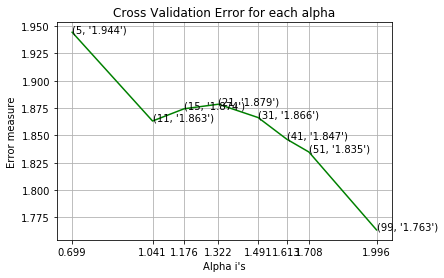

For values of best alpha =  99 The train log loss is: 1.396676792654822
For values of best alpha =  99 The cross validation log loss is: 1.763487966172793
For values of best alpha =  99 The test log loss is: 1.7952820746914535
For values of best alpha =  99 The ratio of misclassified is: 75.0


In [31]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier


alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for number of neighbors =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["KNeighborsClassifier", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on response coding data and with no class balancing

for number of neighbors = 5
Log Loss : 1.9560734064517336
for number of neighbors = 11
Log Loss : 1.8651388068290047
for number of neighbors = 15
Log Loss : 1.876043972272596
for number of neighbors = 21
Log Loss : 1.8785096555589973
for number of neighbors = 31
Log Loss : 1.864494137724005
for number of neighbors = 41
Log Loss : 1.8468025017092355
for number of neighbors = 51
Log Loss : 1.8351794065310751
for number of neighbors = 99
Log Loss : 1.7634016499381509


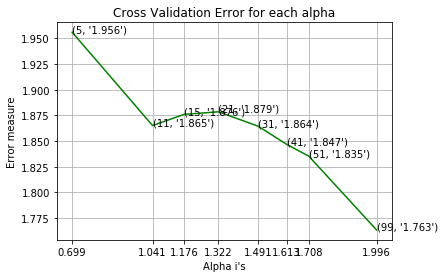

For values of best alpha =  99 The train log loss is: 1.3946444169860142
For values of best alpha =  99 The cross validation log loss is: 1.7634016499381509
For values of best alpha =  99 The test log loss is: 1.795705981330362
For values of best alpha =  99 The ratio of misclassified is: 75.45180722891565


In [32]:
# hyper parameter tuning

alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for number of neighbors =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["KNeighborsClassifier", "Responce", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

## Logistic Regression

### Training on one hot data and with class balancing

for alpha = 1e-06
Log Loss : 1.8315841517469778
for alpha = 1e-05
Log Loss : 1.8191676925689624
for alpha = 0.0001
Log Loss : 1.8205714943757643
for alpha = 0.001
Log Loss : 1.8300014330931735
for alpha = 0.01
Log Loss : 1.789656998294292
for alpha = 0.1
Log Loss : 1.8020057224201376
for alpha = 1
Log Loss : 1.8418480480718573
for alpha = 10
Log Loss : 1.7936880700588569
for alpha = 100
Log Loss : 1.7438589238024285


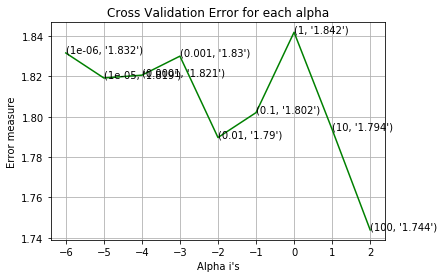

For values of best alpha =  100 The train log loss is: 1.2292820325797869
For values of best alpha =  100 The cross validation log loss is: 1.7413395112381027
For values of best alpha =  100 The test log loss is: 1.7427947260602263
For values of best alpha =  100 The ratio of misclassified is: 64.7590361445783


In [33]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log')
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["SGD Classifier", "One hot", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on one hot data and with no class balancing

for alpha = 1e-06
Log Loss : 1.8315841517469778
for alpha = 1e-05
Log Loss : 1.8336647386493448
for alpha = 0.0001
Log Loss : 1.8244283454492491
for alpha = 0.001
Log Loss : 1.8085688704363707
for alpha = 0.01
Log Loss : 1.8555148347355364
for alpha = 0.1
Log Loss : 1.8389445317432944
for alpha = 1
Log Loss : 1.8320269966988811
for alpha = 10
Log Loss : 1.813654605342755
for alpha = 100
Log Loss : 1.7553282685405802


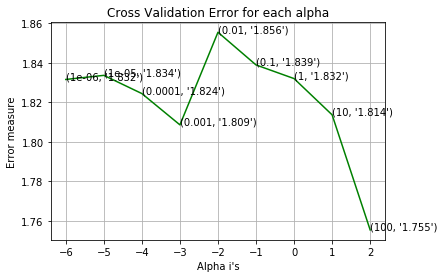

For values of best alpha =  100 The train log loss is: 1.2247593538585955
For values of best alpha =  100 The cross validation log loss is: 1.7563932800625122
For values of best alpha =  100 The test log loss is: 1.7424119185537406
For values of best alpha =  100 The ratio of misclassified is: 61.74698795180723


In [34]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log')
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["SGD Classifier", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and with class balancing

for alpha = 1e-06
Log Loss : 1.8315841517469778
for alpha = 1e-05
Log Loss : 1.8252014137326735
for alpha = 0.0001
Log Loss : 1.857074949018021
for alpha = 0.001
Log Loss : 1.822626827236345
for alpha = 0.01
Log Loss : 1.843774057608907
for alpha = 0.1
Log Loss : 1.8314396064219436
for alpha = 1
Log Loss : 1.8377246101593325
for alpha = 10
Log Loss : 1.797411960698674
for alpha = 100
Log Loss : 1.7440000890874359


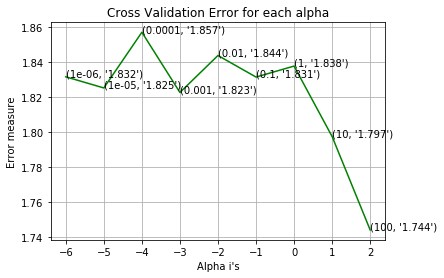

For values of best alpha =  100 The train log loss is: 1.2460403716934945
For values of best alpha =  100 The cross validation log loss is: 1.7469586019626726
For values of best alpha =  100 The test log loss is: 1.7487746667085906
For values of best alpha =  100 The ratio of misclassified is: 64.60843373493977


In [35]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log')
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["SGD Classifier", "Response", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and no with class balancing

for alpha = 1e-06
Log Loss : 1.8315841517469778
for alpha = 1e-05
Log Loss : 1.8275724595083034
for alpha = 0.0001
Log Loss : 1.8313827641589304
for alpha = 0.001
Log Loss : 1.821685009071054
for alpha = 0.01
Log Loss : 1.8184720140496657
for alpha = 0.1
Log Loss : 1.8129418241145168
for alpha = 1
Log Loss : 1.821466275668566
for alpha = 10
Log Loss : 1.8205613327963592
for alpha = 100
Log Loss : 1.7506981248381195


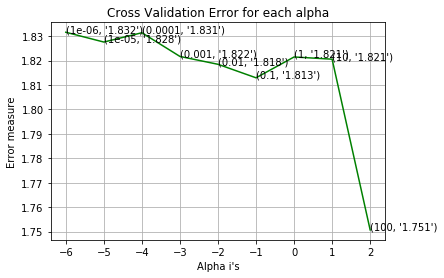

For values of best alpha =  100 The train log loss is: 1.2296883308851867
For values of best alpha =  100 The cross validation log loss is: 1.7529691633719742
For values of best alpha =  100 The test log loss is: 1.74478029622105
For values of best alpha =  100 The ratio of misclassified is: 62.5


In [36]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log')
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["SGD Classifier", "Response", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

## Linear Support Vector Machines

### Training on one hot data and with class balancing

for alpha = 1e-06
Log Loss : 1.8315841517469778
for alpha = 1e-05
Log Loss : 1.8315841517469778
for alpha = 0.0001
Log Loss : 1.8375235520474704
for alpha = 0.001
Log Loss : 1.8215085568725846
for alpha = 0.01
Log Loss : 1.792977461566755
for alpha = 0.1
Log Loss : 1.8376095979319438
for alpha = 1
Log Loss : 1.8340049181588765
for alpha = 10
Log Loss : 1.7988202007399736
for alpha = 100
Log Loss : 1.778669666032302


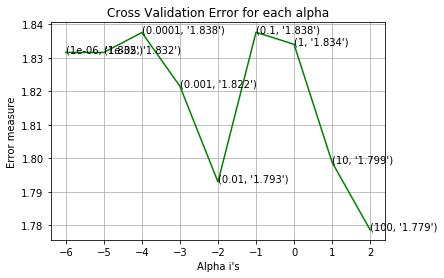

For values of best alpha =  100 The train log loss is: 1.2601316795905009
For values of best alpha =  100 The cross validation log loss is: 1.7787492787245085
For values of best alpha =  100 The test log loss is: 1.7694129826597982
For values of best alpha =  100 The ratio of misclassified is: 67.7710843373494


In [37]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge')
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge')
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Linear SVM", "One hot", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on one hot data and with no class balancing

for alpha = 1e-06
Log Loss : 1.8315841517469778
for alpha = 1e-05
Log Loss : 1.8353024194361218
for alpha = 0.0001
Log Loss : 1.8319220484156926
for alpha = 0.001
Log Loss : 1.8471266583435615
for alpha = 0.01
Log Loss : 1.8238541692186434
for alpha = 0.1
Log Loss : 1.8421001940717072
for alpha = 1
Log Loss : 1.8358115437955052
for alpha = 10
Log Loss : 1.8476269460908623
for alpha = 100
Log Loss : 1.7929156941778923


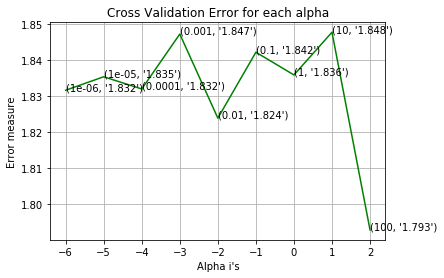

For values of best alpha =  100 The train log loss is: 1.2123595245806382
For values of best alpha =  100 The cross validation log loss is: 1.784814552007806
For values of best alpha =  100 The test log loss is: 1.7578788024676497
For values of best alpha =  100 The ratio of misclassified is: 65.51204819277109


In [38]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge')
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge')
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Linear SVM", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and with class balancing

for alpha = 1e-06
Log Loss : 1.8315841517469778
for alpha = 1e-05
Log Loss : 1.8315841517469778
for alpha = 0.0001
Log Loss : 1.8064850888848871
for alpha = 0.001
Log Loss : 1.8226233767061262
for alpha = 0.01
Log Loss : 1.8107976369233578
for alpha = 0.1
Log Loss : 1.7898668330863121
for alpha = 1
Log Loss : 1.8074629669373232
for alpha = 10
Log Loss : 1.8343454077180155
for alpha = 100
Log Loss : 1.7763127452321499


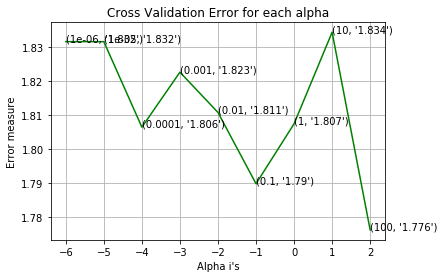

For values of best alpha =  100 The train log loss is: 1.242469751370496
For values of best alpha =  100 The cross validation log loss is: 1.7724841218666083
For values of best alpha =  100 The test log loss is: 1.7691790865054422
For values of best alpha =  100 The ratio of misclassified is: 67.46987951807229


In [39]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge')
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge')
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Linear SVM", "Response", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and no with class balancing

for alpha = 1e-06
Log Loss : 1.8315841517469778
for alpha = 1e-05
Log Loss : 1.8315841517469778
for alpha = 0.0001
Log Loss : 1.8418082076036737
for alpha = 0.001
Log Loss : 1.8657955227671474
for alpha = 0.01
Log Loss : 1.8370972950323827
for alpha = 0.1
Log Loss : 1.8472573388003641
for alpha = 1
Log Loss : 1.8789946665159256
for alpha = 10
Log Loss : 1.8271871443828507
for alpha = 100
Log Loss : 1.7837854602459877


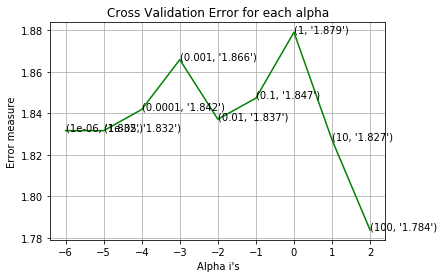

For values of best alpha =  100 The train log loss is: 1.2088104225871636
For values of best alpha =  100 The cross validation log loss is: 1.7866432477101872
For values of best alpha =  100 The test log loss is: 1.7583601065265522
For values of best alpha =  100 The ratio of misclassified is: 62.5


In [40]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge')
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge')
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Linear SVM", "Response", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

##  Random Forest Classifier

### Training on one hot data and with no class balancing

In [41]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier


alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, n_jobs=3)
        clf.fit(one_hot_Train, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(one_hot_Train, train_y)
        sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        # to avoid rounding error while multiplying probabilites we use log-probability estimates
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', 
                             max_depth=max_depth[int(best_alpha%2)], n_jobs=3)

clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Random Forest", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

for n_estimators = 100 and max depth =  5
Log Loss : 1.7210634899461663
for n_estimators = 100 and max depth =  10
Log Loss : 1.8137019688108615
for n_estimators = 200 and max depth =  5
Log Loss : 1.7057138086723533
for n_estimators = 200 and max depth =  10
Log Loss : 1.7727814417653969
for n_estimators = 500 and max depth =  5
Log Loss : 1.7136014592876825
for n_estimators = 500 and max depth =  10
Log Loss : 1.7613380079254233
for n_estimators = 1000 and max depth =  5
Log Loss : 1.7100344537260674
for n_estimators = 1000 and max depth =  10
Log Loss : 1.7642753577277066
for n_estimators = 2000 and max depth =  5
Log Loss : 1.6978375417741178
for n_estimators = 2000 and max depth =  10
Log Loss : 1.7607112577067578
For values of best alpha =  2000 The train log loss is: 0.8852562224389753
For values of best alpha =  2000 The cross validation log loss is: 1.7089401621996259
For values of best alpha =  2000 The test log loss is: 1.7220409610566683
For values of best alpha =  2000 The

### Training on responce coding data and no with class balancing

In [42]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier


alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, n_jobs=3)
        clf.fit(responseCoding_Train, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(responseCoding_Train, train_y)
        sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        # to avoid rounding error while multiplying probabilites we use log-probability estimates
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', 
                             max_depth=max_depth[int(best_alpha%2)], n_jobs=3)

clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Random Forest", "Response", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

for n_estimators = 100 and max depth =  5
Log Loss : 1.4525467541652808
for n_estimators = 100 and max depth =  10
Log Loss : 1.587193798137565
for n_estimators = 200 and max depth =  5
Log Loss : 1.3924443309317034
for n_estimators = 200 and max depth =  10
Log Loss : 1.5718662357625102
for n_estimators = 500 and max depth =  5
Log Loss : 1.490517285088019
for n_estimators = 500 and max depth =  10
Log Loss : 1.5839441129786604
for n_estimators = 1000 and max depth =  5
Log Loss : 1.4424581106806933
for n_estimators = 1000 and max depth =  10
Log Loss : 1.5325479100440302
for n_estimators = 2000 and max depth =  5
Log Loss : 1.4977102571418603
for n_estimators = 2000 and max depth =  10
Log Loss : 1.555206922086145
For values of best alpha =  200 The train log loss is: 0.22968666853635594
For values of best alpha =  200 The cross validation log loss is: 1.4360929476689817
For values of best alpha =  200 The test log loss is: 1.4765473926539143
For values of best alpha =  200 The ratio

## Decision Tree

### Training on one hot data and with class balancing

For max depth =  100
Log Loss : 1.9706734088741051
For max depth =  300
Log Loss : 1.9703640124773014
For max depth =  500
Log Loss : 1.938970381396272
For max depth =  800
Log Loss : 1.85923823354142
For max depth =  1000
Log Loss : 1.9327071216421152
For max depth =  1500
Log Loss : 1.938588434496124
For max depth =  2000
Log Loss : 1.940913660424655


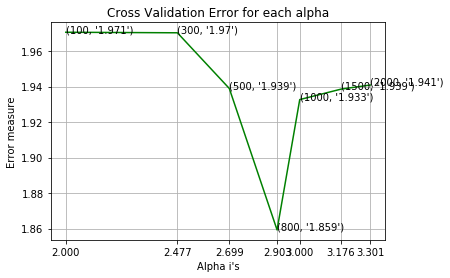

For values of best alpha =  800 The train log loss is: 0.8030016389955178
For values of best alpha =  800 The cross validation log loss is: 1.9115781234160698
For values of best alpha =  800 The test log loss is: 1.8642992658482336
For values of best alpha =  800 The ratio of misclassified is: 73.04216867469879


In [43]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier


alpha = [100, 300, 500, 800, 1000, 1500, 2000]
cv_log_error_array = []
for j in alpha:
    print("For max depth = ", j)
    clf = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=j)
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = DecisionTreeClassifier(class_weight='balanced', criterion='gini', 
                             max_depth=alpha[best_alpha])

clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Decision Tree", "One hot", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on one hot data and with no class balancing

For max depth =  100
Log Loss : 1.9880449406149836
For max depth =  300
Log Loss : 1.9622939598751945
For max depth =  500
Log Loss : 1.9706798207524467
For max depth =  800
Log Loss : 1.9847348716360957
For max depth =  1000
Log Loss : 2.0002697760009838
For max depth =  1500
Log Loss : 1.9499565651493256
For max depth =  2000
Log Loss : 1.9916408542240505


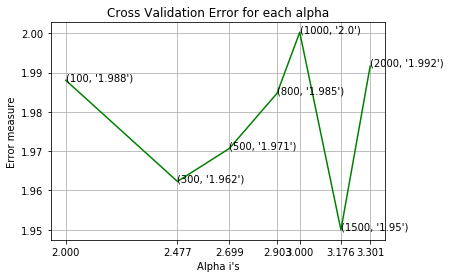

For values of best alpha =  1500 The train log loss is: 0.7899882446030334
For values of best alpha =  1500 The cross validation log loss is: 1.9586382686218364
For values of best alpha =  1500 The test log loss is: 1.8480967247343587
For values of best alpha =  1500 The ratio of misclassified is: 72.13855421686746


In [45]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier


max_depth = [100, 300, 500, 800, 1000, 1500, 2000]
cv_log_error_array = []
for j in max_depth:
    print("For max depth = ", j)
    clf = DecisionTreeClassifier(criterion='gini', max_depth=j)
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = DecisionTreeClassifier(criterion='gini', 
                             max_depth=alpha[best_alpha])

clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Decision Tree", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and with class balancing

For max depth =  100
Log Loss : 3.0048603196019337
For max depth =  300
Log Loss : 2.9713333126388752
For max depth =  500
Log Loss : 2.9721365595090585
For max depth =  800
Log Loss : 3.030871363862807
For max depth =  1000
Log Loss : 3.0208199968905802
For max depth =  1500
Log Loss : 3.0262190567559895
For max depth =  2000
Log Loss : 2.9978883369982716


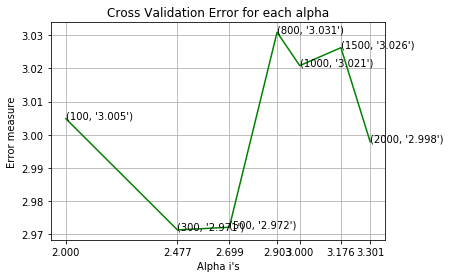

For values of best alpha =  300 The train log loss is: 0.06559977086208736
For values of best alpha =  300 The cross validation log loss is: 2.9763218123460735
For values of best alpha =  300 The test log loss is: 2.977880382542849
For values of best alpha =  300 The ratio of misclassified is: 67.31927710843374


In [46]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier


alpha = [100, 300, 500, 800, 1000, 1500, 2000]
cv_log_error_array = []
for j in alpha:
    print("For max depth = ", j)
    clf = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=j)
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = DecisionTreeClassifier(class_weight='balanced', criterion='gini', 
                             max_depth=alpha[best_alpha])

clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Decision Tree", "response", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and no with class balancing

For max depth =  100
Log Loss : 4.430253154902177
For max depth =  300
Log Loss : 4.3549143336321325
For max depth =  500
Log Loss : 4.456552263309042
For max depth =  800
Log Loss : 4.481738336365169
For max depth =  1000
Log Loss : 4.462033456917533
For max depth =  1500
Log Loss : 4.434715447559568
For max depth =  2000
Log Loss : 4.449810919509357


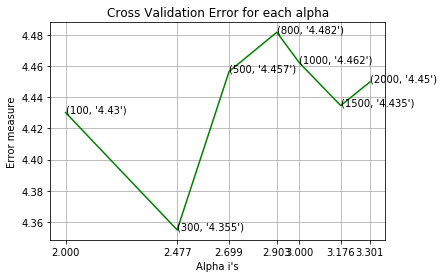

For values of best alpha =  300 The train log loss is: 0.049431993575282954
For values of best alpha =  300 The cross validation log loss is: 4.44947335405081
For values of best alpha =  300 The test log loss is: 4.447949989304014
For values of best alpha =  300 The ratio of misclassified is: 92.7710843373494


In [47]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier


alpha = [100, 300, 500, 800, 1000, 1500, 2000]
cv_log_error_array = []
for j in alpha:
    print("For max depth = ", j)
    clf = DecisionTreeClassifier(criterion='gini', max_depth=j)
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = DecisionTreeClassifier(criterion='gini', 
                             max_depth=alpha[best_alpha])

clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Decision Tree", "response", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

## Stack the models

### Training on one hot encoding with class balancing

In [51]:
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier

clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', 
                     class_weight='balanced', random_state=0)
clf1.fit(one_hot_Train, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', 
                     class_weight='balanced', random_state=0)
clf2.fit(one_hot_Train, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(one_hot_Train, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(one_hot_Train, train_y)
print("Logistic Regression :  Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf1.predict_proba(one_hot_Cv))))
sig_clf2.fit(one_hot_Train, train_y)
print("Support vector machines : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf2.predict_proba(one_hot_Cv))))
sig_clf3.fit(one_hot_Train, train_y)
print("Naive Bayes : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf3.predict_proba(one_hot_Cv))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                              meta_classifier=lr, use_probas=True)
    sclf.fit(one_hot_Train, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" 
          % (i, log_loss(cv_y, sclf.predict_proba(one_hot_Cv))))
    log_error =log_loss(cv_y, sclf.predict_proba(one_hot_Cv))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.83
Support vector machines : Log Loss: 1.83
Naive Bayes : Log Loss: 1.74
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.184
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.101
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.883
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.741
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.823
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.932


In [53]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                          meta_classifier=lr, use_probas=True)
sclf.fit(one_hot_Train, train_y)

te = []
predict_y = sclf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["SGD+SGD+NB", "one hot", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 1.1803121029227546
The cross validation log loss is: 1.7408821517390636
The test log loss is: 1.7518049650258984
The ratio of misclassified is: 65.8132530120482


### Training on one hot encoding with no class balancing

In [54]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', 
                     random_state=0)
clf1.fit(one_hot_Train, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', 
                     random_state=0)
clf2.fit(one_hot_Train, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(one_hot_Train, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(one_hot_Train, train_y)
print("Logistic Regression :  Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf1.predict_proba(one_hot_Cv))))
sig_clf2.fit(one_hot_Train, train_y)
print("Support vector machines : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf2.predict_proba(one_hot_Cv))))
sig_clf3.fit(one_hot_Train, train_y)
print("Naive Bayes : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf3.predict_proba(one_hot_Cv))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                              meta_classifier=lr, use_probas=True)
    sclf.fit(one_hot_Train, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" 
          % (i, log_loss(cv_y, sclf.predict_proba(one_hot_Cv))))
    log_error =log_loss(cv_y, sclf.predict_proba(one_hot_Cv))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.83
Support vector machines : Log Loss: 1.82
Naive Bayes : Log Loss: 1.74
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.184
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.100
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.879
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.743
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.810
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.900


In [55]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                          meta_classifier=lr, use_probas=True)
sclf.fit(one_hot_Train, train_y)

te = []
predict_y = sclf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["SGD+SGD+NB", "one hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 1.1592659219639665
The cross validation log loss is: 1.7430354595527158
The test log loss is: 1.7557837740036608
The ratio of misclassified is: 66.41566265060241


### Training on response coding with class balancing

In [56]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', 
                     class_weight='balanced', random_state=0)
clf1.fit(responseCoding_Train, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', 
                     class_weight='balanced', random_state=0)
clf2.fit(responseCoding_Train, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(responseCoding_Train, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(responseCoding_Train, train_y)
print("Logistic Regression :  Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf1.predict_proba(responseCoding_Cv))))
sig_clf2.fit(responseCoding_Train, train_y)
print("Support vector machines : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf2.predict_proba(responseCoding_Cv))))
sig_clf3.fit(responseCoding_Train, train_y)
print("Naive Bayes : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf3.predict_proba(responseCoding_Cv))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                              meta_classifier=lr, use_probas=True)
    sclf.fit(responseCoding_Train, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" 
          % (i, log_loss(cv_y, sclf.predict_proba(responseCoding_Cv))))
    log_error =log_loss(cv_y, sclf.predict_proba(responseCoding_Cv))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.84
Support vector machines : Log Loss: 1.82
Naive Bayes : Log Loss: 1.75
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.184
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.101
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.883
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.746
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.831
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.945


In [57]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                          meta_classifier=lr, use_probas=True)
sclf.fit(responseCoding_Train, train_y)

te = []
predict_y = sclf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["SGD+SGD+NB", "response", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 1.1866467296188608
The cross validation log loss is: 1.7458634429643516
The test log loss is: 1.7560973359408505
The ratio of misclassified is: 67.92168674698796


### Training on response coding with no class balancing

In [58]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', 
                     random_state=0)
clf1.fit(responseCoding_Train, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', 
                     random_state=0)
clf2.fit(responseCoding_Train, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(responseCoding_Train, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(responseCoding_Train, train_y)
print("Logistic Regression :  Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf1.predict_proba(responseCoding_Cv))))
sig_clf2.fit(responseCoding_Train, train_y)
print("Support vector machines : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf2.predict_proba(responseCoding_Cv))))
sig_clf3.fit(responseCoding_Train, train_y)
print("Naive Bayes : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf3.predict_proba(responseCoding_Cv))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                              meta_classifier=lr, use_probas=True)
    sclf.fit(responseCoding_Train, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" 
          % (i, log_loss(cv_y, sclf.predict_proba(responseCoding_Cv))))
    log_error =log_loss(cv_y, sclf.predict_proba(responseCoding_Cv))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.82
Support vector machines : Log Loss: 1.82
Naive Bayes : Log Loss: 1.75
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.184
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.100
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.880
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.750
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.822
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.918


In [59]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                          meta_classifier=lr, use_probas=True)
sclf.fit(responseCoding_Train, train_y)

te = []
predict_y = sclf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["SGD+SGD+NB", "response", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 1.1538318486009735
The cross validation log loss is: 1.7504022892852027
The test log loss is: 1.7634090647106715
The ratio of misclassified is: 67.31927710843374


## Maximum voting Classifier

### Training on one hot encoding data with no class balancing

In [60]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], 
                        voting='soft')
sclf.fit(one_hot_Train, train_y)

te = []
predict_y = sclf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["Max Voting", "one hot", "No", round(te[0], 3),
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 1.1592659219639665
The cross validation log loss is: 1.7430354595527158
The test log loss is: 1.7557837740036608
The ratio of misclassified is: 66.41566265060241


### Training on response coding data with no class balancing`

In [61]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], 
                        voting='soft')
sclf.fit(responseCoding_Train, train_y)

te = []
predict_y = sclf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["Max Voting", "response", "No", round(te[0], 3),
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 1.1538318486009735
The cross validation log loss is: 1.7504022892852027
The test log loss is: 1.7634090647106715
The ratio of misclassified is: 67.31927710843374


#  Tf-Idf

## Featurize: Text
* Building tfidf vectorizer by taking max 1500 feature.

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer(max_features=1500)
tfidf_Train = tfidf_model.fit_transform(train_x['TEXT'])
tfidf_Cv = tfidf_model.fit_transform(cv_x['TEXT'])
tfidf_Test = tfidf_model.fit_transform(test_x['TEXT'])

In [72]:
print("Structure of Text data: ")
print("Shape of tfidf train text: ", tfidf_Train.shape)
print("Shape of tfidf cv text: ", tfidf_Cv.shape)
print("Shape of tfidf test text: ", tfidf_Test.shape)

Structure of Text data: 
Shape of tfidf train text:  (2121, 1500)
Shape of tfidf cv text:  (531, 1500)
Shape of tfidf test text:  (664, 1500)


## Stacking features

In [73]:
from scipy.sparse import hstack

one_hot_Train = hstack((one_hot_geneTrain, one_hot_variationTrain, tfidf_Train))
one_hot_Cv = hstack((one_hot_geneCv, one_hot_variationCv, tfidf_Cv))
one_hot_Test = hstack((one_hot_geneTest, one_hot_variationTest, tfidf_Test))

In [74]:
print("Structure of Total one hot data: ")
print("Shape of one hot train data: ", one_hot_Train.shape)
print("Shape of one hot cv data: ", one_hot_Cv.shape)
print("Shape of one hot test data: ", one_hot_Test.shape)

Structure of Total one hot data: 
Shape of one hot train data:  (2121, 3695)
Shape of one hot cv data:  (531, 3695)
Shape of one hot test data:  (664, 3695)


In [75]:
from scipy.sparse import hstack

responseCoding_Train = hstack((responseCoding_geneTrain, responseCoding_variationTrain, tfidf_Train))
responseCoding_Cv = hstack((responseCoding_geneCv, responseCoding_variationCv, tfidf_Cv))
responseCoding_Test = hstack((responseCoding_geneTest, responseCoding_variationTest, tfidf_Test))

In [76]:
print("Structure of Total one hot data: ")
print("Shape of one hot train data: ", responseCoding_Train.shape)
print("Shape of one hot cv data: ", responseCoding_Cv.shape)
print("Shape of one hot test data: ", responseCoding_Test.shape)

Structure of Total one hot data: 
Shape of one hot train data:  (2121, 1518)
Shape of one hot cv data:  (531, 1518)
Shape of one hot test data:  (664, 1518)


# Machine Learning Models

## Naive Bayes

### Training on one hot data and with no class balancing

for alpha = 1e-05
Log Loss : 1.3377198295071626
for alpha = 0.0001
Log Loss : 1.3334068170107443
for alpha = 0.001
Log Loss : 1.3266446228206719
for alpha = 0.1
Log Loss : 1.303551644358316
for alpha = 1
Log Loss : 1.3185550820889471
for alpha = 10
Log Loss : 1.4752525138090244
for alpha = 100
Log Loss : 1.5281245017675622
for alpha = 1000
Log Loss : 1.5339829098575561


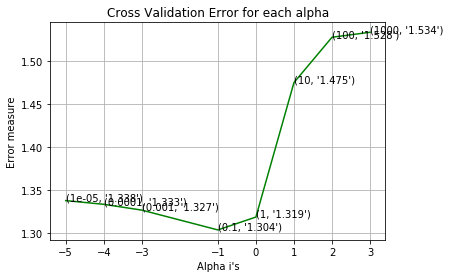

For values of best alpha =  0.1 The train log loss is: 0.7036188790285749
For values of best alpha =  0.1 The cross validation log loss is: 1.303551644358316
For values of best alpha =  0.1 The test log loss is: 1.272357902906925
For values of best alpha =  0.1 The ratio of misclassified is: 40.963855421686745


In [77]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence = []
performence.append(["Naive Bayes", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on response coding data and with no class balancing

for alpha = 1e-05
Log Loss : 1.674380130712714
for alpha = 0.0001
Log Loss : 1.6725407691471108
for alpha = 0.001
Log Loss : 1.670260455796253
for alpha = 0.1
Log Loss : 1.736815300957397
for alpha = 1
Log Loss : 2.2661680248305918
for alpha = 10
Log Loss : 2.0187257855574074
for alpha = 100
Log Loss : 1.780431528553535
for alpha = 1000
Log Loss : 1.7310239331755843


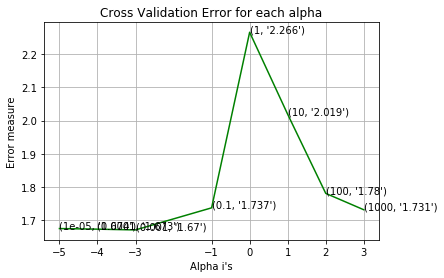

For values of best alpha =  0.001 The train log loss is: 1.1047825862652436
For values of best alpha =  0.001 The cross validation log loss is: 1.670260455796253
For values of best alpha =  0.001 The test log loss is: 1.653902926760268
For values of best alpha =  0.001 The ratio of misclassified is: 60.09036144578314


In [78]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Naive Bayes", "Responce", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

## K Nearest Neighbour Classification

### Training on one hot data and with no class balancing

for number of neighbors = 5
Log Loss : 1.3680457604189498
for number of neighbors = 11
Log Loss : 1.310870519850333
for number of neighbors = 15
Log Loss : 1.323438201483435
for number of neighbors = 21
Log Loss : 1.363380919317079
for number of neighbors = 31
Log Loss : 1.412622820964841
for number of neighbors = 41
Log Loss : 1.4289121523480186
for number of neighbors = 51
Log Loss : 1.4338787101791401
for number of neighbors = 99
Log Loss : 1.4729089987752078


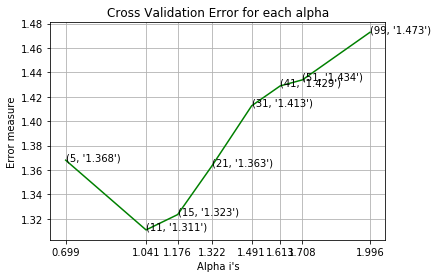

For values of best alpha =  11 The train log loss is: 0.9979384412452205
For values of best alpha =  11 The cross validation log loss is: 1.310870519850333
For values of best alpha =  11 The test log loss is: 1.2731569422361697
For values of best alpha =  11 The ratio of misclassified is: 46.234939759036145


In [79]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier


alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for number of neighbors =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["KNeighborsClassifier", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on response coding data and with no class balancing

for number of neighbors = 5
Log Loss : 1.8105150765797429
for number of neighbors = 11
Log Loss : 1.714610866873158
for number of neighbors = 15
Log Loss : 1.6854129151834958
for number of neighbors = 21
Log Loss : 1.666740725800785
for number of neighbors = 31
Log Loss : 1.6287982660338476
for number of neighbors = 41
Log Loss : 1.604391959632673
for number of neighbors = 51
Log Loss : 1.5965615923373224
for number of neighbors = 99
Log Loss : 1.5140696808884437


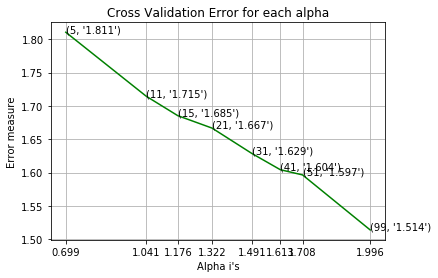

For values of best alpha =  99 The train log loss is: 1.2384129073624248
For values of best alpha =  99 The cross validation log loss is: 1.5140696808884437
For values of best alpha =  99 The test log loss is: 1.465883531507054
For values of best alpha =  99 The ratio of misclassified is: 52.108433734939766


In [80]:
# hyper parameter tuning

alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for number of neighbors =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["KNeighborsClassifier", "Responce", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

## Logistic Regression

### Training on one hot data and with class balancing

for alpha = 1e-06
Log Loss : 1.5022346933070785
for alpha = 1e-05
Log Loss : 1.4599212474088616
for alpha = 0.0001
Log Loss : 1.3309038999193161
for alpha = 0.001
Log Loss : 1.303277163699535
for alpha = 0.01
Log Loss : 1.4435310444382423
for alpha = 0.1
Log Loss : 1.630414652253677
for alpha = 1
Log Loss : 1.6882523869681836
for alpha = 10
Log Loss : 1.6948858393191457
for alpha = 100
Log Loss : 1.695721083692532


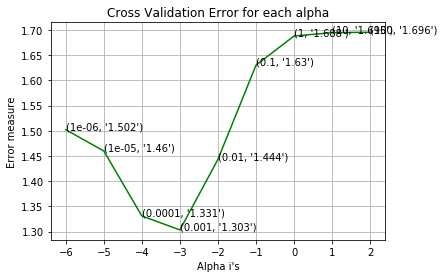

For values of best alpha =  0.001 The train log loss is: 0.7058299529718406
For values of best alpha =  0.001 The cross validation log loss is: 1.303503119735414
For values of best alpha =  0.001 The test log loss is: 1.2684381661105597
For values of best alpha =  0.001 The ratio of misclassified is: 44.57831325301205


In [81]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log')
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["SGD Classifier", "One hot", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on one hot data and with no class balancing

for alpha = 1e-06
Log Loss : 1.4841698098922806
for alpha = 1e-05
Log Loss : 1.4458488399081795
for alpha = 0.0001
Log Loss : 1.3377688350215609
for alpha = 0.001
Log Loss : 1.3316250426127596
for alpha = 0.01
Log Loss : 1.4400812376741878
for alpha = 0.1
Log Loss : 1.5833251540176565
for alpha = 1
Log Loss : 1.635775194054668
for alpha = 10
Log Loss : 1.6430932332318275
for alpha = 100
Log Loss : 1.6440537028857594


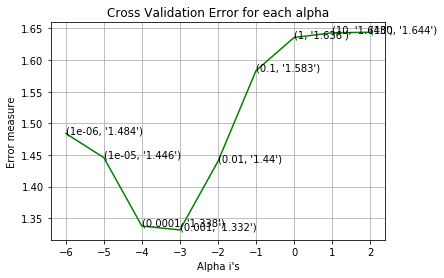

For values of best alpha =  0.001 The train log loss is: 0.7186583477247006
For values of best alpha =  0.001 The cross validation log loss is: 1.3337721307203463
For values of best alpha =  0.001 The test log loss is: 1.2979293834562218
For values of best alpha =  0.001 The ratio of misclassified is: 44.27710843373494


In [82]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log')
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["SGD Classifier", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and with class balancing

for alpha = 1e-06
Log Loss : 1.5605293811604206
for alpha = 1e-05
Log Loss : 1.54948556544287
for alpha = 0.0001
Log Loss : 1.4553102822481556
for alpha = 0.001
Log Loss : 1.4316747944883057
for alpha = 0.01
Log Loss : 1.5293201396735698
for alpha = 0.1
Log Loss : 1.7099772816909737
for alpha = 1
Log Loss : 1.7752790703340338
for alpha = 10
Log Loss : 1.7819117771214426
for alpha = 100
Log Loss : 1.7826466109005854


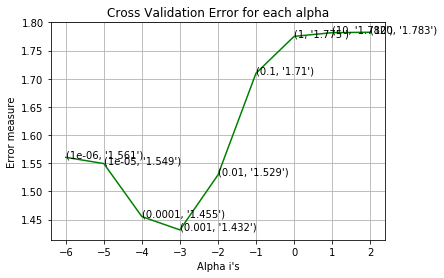

For values of best alpha =  0.001 The train log loss is: 0.9140608701100769
For values of best alpha =  0.001 The cross validation log loss is: 1.4303523162856828
For values of best alpha =  0.001 The test log loss is: 1.4198243018084507
For values of best alpha =  0.001 The ratio of misclassified is: 48.94578313253012


In [83]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log')
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["SGD Classifier", "Response", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and no with class balancing

for alpha = 1e-06
Log Loss : 1.5560208332507566
for alpha = 1e-05
Log Loss : 1.5633386956533255
for alpha = 0.0001
Log Loss : 1.479538075883705
for alpha = 0.001
Log Loss : 1.4393581219637726
for alpha = 0.01
Log Loss : 1.5160260295421435
for alpha = 0.1
Log Loss : 1.668043102026099
for alpha = 1
Log Loss : 1.731236577730605
for alpha = 10
Log Loss : 1.7412462274482285
for alpha = 100
Log Loss : 1.7424019096933887


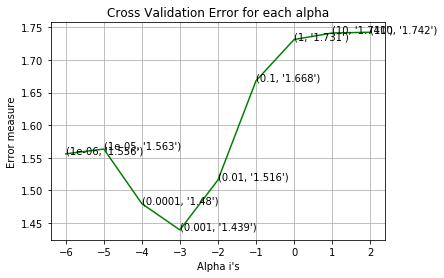

For values of best alpha =  0.001 The train log loss is: 0.9293470141759034
For values of best alpha =  0.001 The cross validation log loss is: 1.4383167702455333
For values of best alpha =  0.001 The test log loss is: 1.4230696806112921
For values of best alpha =  0.001 The ratio of misclassified is: 47.13855421686747


In [84]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log')
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["SGD Classifier", "Response", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

## Linear Support Vector Machines

### Training on one hot data and with class balancing

for alpha = 1e-06
Log Loss : 1.476275373898737
for alpha = 1e-05
Log Loss : 1.473294793746758
for alpha = 0.0001
Log Loss : 1.4251190185168598
for alpha = 0.001
Log Loss : 1.4202036247609569
for alpha = 0.01
Log Loss : 1.541977288760973
for alpha = 0.1
Log Loss : 1.6784594222666789
for alpha = 1
Log Loss : 1.6959030074992394
for alpha = 10
Log Loss : 1.6959085006687094
for alpha = 100
Log Loss : 1.6959085033851449


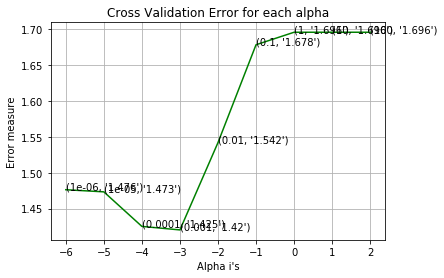

For values of best alpha =  0.001 The train log loss is: 0.6211755324758574
For values of best alpha =  0.001 The cross validation log loss is: 1.4188584569492608
For values of best alpha =  0.001 The test log loss is: 1.381215445404207
For values of best alpha =  0.001 The ratio of misclassified is: 44.126506024096386


In [85]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge')
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge')
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Linear SVM", "One hot", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on one hot data and with no class balancing

for alpha = 1e-06
Log Loss : 1.4904461027883498
for alpha = 1e-05
Log Loss : 1.457366840393686
for alpha = 0.0001
Log Loss : 1.430008281655785
for alpha = 0.001
Log Loss : 1.4139190129212142
for alpha = 0.01
Log Loss : 1.5605027940104612
for alpha = 0.1
Log Loss : 1.6268596915215543
for alpha = 1
Log Loss : 1.6443505001548466
for alpha = 10
Log Loss : 1.6443509503258968
for alpha = 100
Log Loss : 1.6443505051998983


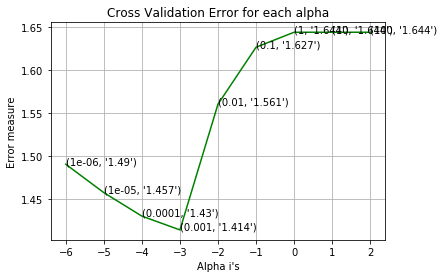

For values of best alpha =  0.001 The train log loss is: 0.5471096658479659
For values of best alpha =  0.001 The cross validation log loss is: 1.4053424812295858
For values of best alpha =  0.001 The test log loss is: 1.364125447401797
For values of best alpha =  0.001 The ratio of misclassified is: 45.03012048192771


In [86]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge')
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge')
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Linear SVM", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and with class balancing

for alpha = 1e-06
Log Loss : 1.5348980096316798
for alpha = 1e-05
Log Loss : 1.5710457078662903
for alpha = 0.0001
Log Loss : 1.5310383568515935
for alpha = 0.001
Log Loss : 1.5124751360669533
for alpha = 0.01
Log Loss : 1.5855577899249358
for alpha = 0.1
Log Loss : 1.7433509399210474
for alpha = 1
Log Loss : 1.7827756694444408
for alpha = 10
Log Loss : 1.7827756664625012
for alpha = 100
Log Loss : 1.782775673514996


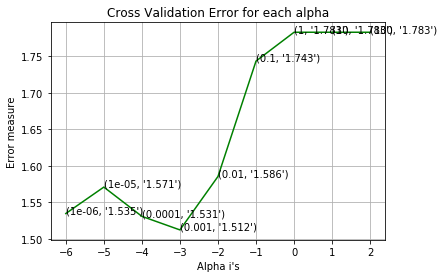

For values of best alpha =  0.001 The train log loss is: 0.9292504747285478
For values of best alpha =  0.001 The cross validation log loss is: 1.5104691294202859
For values of best alpha =  0.001 The test log loss is: 1.5151351456542868
For values of best alpha =  0.001 The ratio of misclassified is: 53.6144578313253


In [87]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge')
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge')
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Linear SVM", "Response", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and no with class balancing

for alpha = 1e-06
Log Loss : 1.5734493189099443
for alpha = 1e-05
Log Loss : 1.572685864507018
for alpha = 0.0001
Log Loss : 1.5470481412523254
for alpha = 0.001
Log Loss : 1.511691344678293
for alpha = 0.01
Log Loss : 1.610012082889692
for alpha = 0.1
Log Loss : 1.7003482875690685
for alpha = 1
Log Loss : 1.7426747272207739
for alpha = 10
Log Loss : 1.7426746956655836
for alpha = 100
Log Loss : 1.7426747243117091


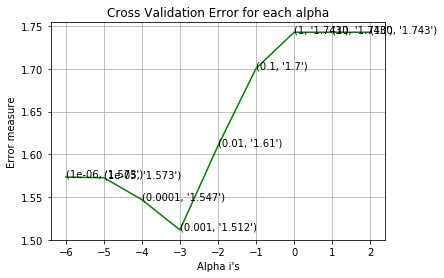

For values of best alpha =  0.001 The train log loss is: 0.9029866732023661
For values of best alpha =  0.001 The cross validation log loss is: 1.5180011113625833
For values of best alpha =  0.001 The test log loss is: 1.5075423194339599
For values of best alpha =  0.001 The ratio of misclassified is: 51.35542168674698


In [88]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge')
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge')
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Linear SVM", "Response", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

##  Random Forest Classifier

### Training on one hot data and with no class balancing

In [89]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier


alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, n_jobs=3)
        clf.fit(one_hot_Train, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(one_hot_Train, train_y)
        sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        # to avoid rounding error while multiplying probabilites we use log-probability estimates
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', 
                             max_depth=max_depth[int(best_alpha%2)], n_jobs=3)

clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Random Forest", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

for n_estimators = 100 and max depth =  5
Log Loss : 1.7180119021463696
for n_estimators = 100 and max depth =  10
Log Loss : 1.7629145138875173
for n_estimators = 200 and max depth =  5
Log Loss : 1.693059055781813
for n_estimators = 200 and max depth =  10
Log Loss : 1.7407068792436355
for n_estimators = 500 and max depth =  5
Log Loss : 1.6891516708561076
for n_estimators = 500 and max depth =  10
Log Loss : 1.7473304129113914
for n_estimators = 1000 and max depth =  5
Log Loss : 1.6927299944492553
for n_estimators = 1000 and max depth =  10
Log Loss : 1.747619789907642
for n_estimators = 2000 and max depth =  5
Log Loss : 1.686327968666024
for n_estimators = 2000 and max depth =  10
Log Loss : 1.7461033184529795
For values of best alpha =  2000 The train log loss is: 0.8348731730344496
For values of best alpha =  2000 The cross validation log loss is: 1.6873905432743506
For values of best alpha =  2000 The test log loss is: 1.6971890362255801
For values of best alpha =  2000 The ra

### Training on responce coding data and no with class balancing

In [90]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier


alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, n_jobs=3)
        clf.fit(responseCoding_Train, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(responseCoding_Train, train_y)
        sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        # to avoid rounding error while multiplying probabilites we use log-probability estimates
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', 
                             max_depth=max_depth[int(best_alpha%2)], n_jobs=3)

clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Random Forest", "Response", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

for n_estimators = 100 and max depth =  5
Log Loss : 1.5076124674178797
for n_estimators = 100 and max depth =  10
Log Loss : 1.454952161794833
for n_estimators = 200 and max depth =  5
Log Loss : 1.4783311393174958
for n_estimators = 200 and max depth =  10
Log Loss : 1.513073214865722
for n_estimators = 500 and max depth =  5
Log Loss : 1.4848780569589113
for n_estimators = 500 and max depth =  10
Log Loss : 1.469172551953051
for n_estimators = 1000 and max depth =  5
Log Loss : 1.488968309470816
for n_estimators = 1000 and max depth =  10
Log Loss : 1.456159203642335
for n_estimators = 2000 and max depth =  5
Log Loss : 1.5180310340910572
for n_estimators = 2000 and max depth =  10
Log Loss : 1.4624561034759582
For values of best alpha =  100 The train log loss is: 0.15491951975064436
For values of best alpha =  100 The cross validation log loss is: 1.4926454023845668
For values of best alpha =  100 The test log loss is: 1.5037488828050143
For values of best alpha =  100 The ratio o

## Decision Tree

### Training on one hot data and with class balancing

For max depth =  100
Log Loss : 1.9725316546974114
For max depth =  300
Log Loss : 1.9134422831544864
For max depth =  500
Log Loss : 1.9279778020556915
For max depth =  800
Log Loss : 1.9280530714880122
For max depth =  1000
Log Loss : 1.941004720953301
For max depth =  1500
Log Loss : 1.955072732395188
For max depth =  2000
Log Loss : 1.944220090873015


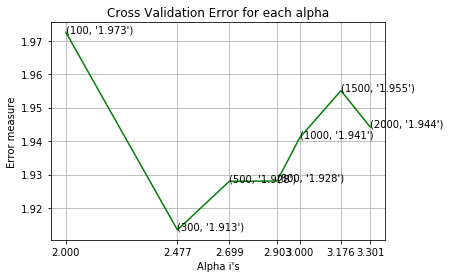

For values of best alpha =  300 The train log loss is: 0.840745572858159
For values of best alpha =  300 The cross validation log loss is: 1.9489538418260244
For values of best alpha =  300 The test log loss is: 1.955065482322723
For values of best alpha =  300 The ratio of misclassified is: 79.81927710843374


In [91]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier


alpha = [100, 300, 500, 800, 1000, 1500, 2000]
cv_log_error_array = []
for j in alpha:
    print("For max depth = ", j)
    clf = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=j)
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = DecisionTreeClassifier(class_weight='balanced', criterion='gini', 
                             max_depth=alpha[best_alpha])

clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Decision Tree", "One hot", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on one hot data and with no class balancing

For max depth =  100
Log Loss : 1.9194023722728992
For max depth =  300
Log Loss : 1.9175374836065742
For max depth =  500
Log Loss : 1.9367659793707648
For max depth =  800
Log Loss : 1.9228177608805035
For max depth =  1000
Log Loss : 1.9319225616901916
For max depth =  1500
Log Loss : 1.9464925026495223
For max depth =  2000
Log Loss : 1.8997769837618135


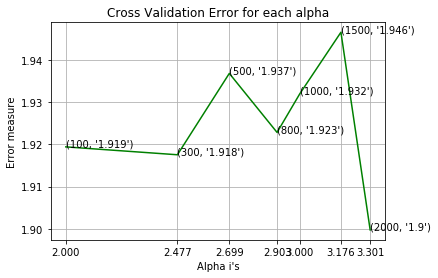

For values of best alpha =  2000 The train log loss is: 0.8031192708049172
For values of best alpha =  2000 The cross validation log loss is: 1.9352274324404697
For values of best alpha =  2000 The test log loss is: 1.8631140316962609
For values of best alpha =  2000 The ratio of misclassified is: 71.23493975903614


In [92]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier


max_depth = [100, 300, 500, 800, 1000, 1500, 2000]
cv_log_error_array = []
for j in max_depth:
    print("For max depth = ", j)
    clf = DecisionTreeClassifier(criterion='gini', max_depth=j)
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = DecisionTreeClassifier(criterion='gini', 
                             max_depth=alpha[best_alpha])

clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Decision Tree", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and with class balancing

For max depth =  100
Log Loss : 2.9983656676054604
For max depth =  300
Log Loss : 2.9583654507023747
For max depth =  500
Log Loss : 2.9839526230863336
For max depth =  800
Log Loss : 3.02269343887073
For max depth =  1000
Log Loss : 2.9799507909835445
For max depth =  1500
Log Loss : 2.990873564528943
For max depth =  2000
Log Loss : 2.9787431850193626


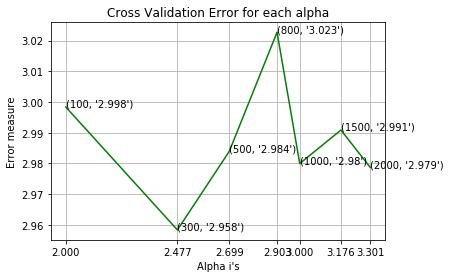

For values of best alpha =  300 The train log loss is: 0.057511608479998005
For values of best alpha =  300 The cross validation log loss is: 3.022708739306455
For values of best alpha =  300 The test log loss is: 3.0423410748468953
For values of best alpha =  300 The ratio of misclassified is: 68.37349397590361


In [93]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier


alpha = [100, 300, 500, 800, 1000, 1500, 2000]
cv_log_error_array = []
for j in alpha:
    print("For max depth = ", j)
    clf = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=j)
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = DecisionTreeClassifier(class_weight='balanced', criterion='gini', 
                             max_depth=alpha[best_alpha])

clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Decision Tree", "response", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and no with class balancing

For max depth =  100
Log Loss : 4.226069118687916
For max depth =  300
Log Loss : 4.270684334643017
For max depth =  500
Log Loss : 4.243152856787222
For max depth =  800
Log Loss : 4.315642132116957
For max depth =  1000
Log Loss : 4.330406417433392
For max depth =  1500
Log Loss : 4.191170462337755
For max depth =  2000
Log Loss : 4.3589032404007115


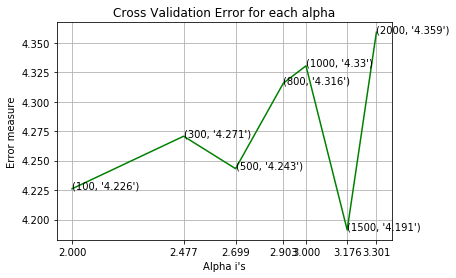

For values of best alpha =  1500 The train log loss is: 0.05885022429762207
For values of best alpha =  1500 The cross validation log loss is: 4.306167997397587
For values of best alpha =  1500 The test log loss is: 4.295198054132573
For values of best alpha =  1500 The ratio of misclassified is: 92.16867469879519


In [94]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier


alpha = [100, 300, 500, 800, 1000, 1500, 2000]
cv_log_error_array = []
for j in alpha:
    print("For max depth = ", j)
    clf = DecisionTreeClassifier(criterion='gini', max_depth=j)
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = DecisionTreeClassifier(criterion='gini', 
                             max_depth=alpha[best_alpha])

clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Decision Tree", "response", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

## Stack the models

### Training on one hot encoding with class balancing

In [95]:
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier

clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', 
                     class_weight='balanced', random_state=0)
clf1.fit(one_hot_Train, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', 
                     class_weight='balanced', random_state=0)
clf2.fit(one_hot_Train, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(one_hot_Train, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(one_hot_Train, train_y)
print("Logistic Regression :  Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf1.predict_proba(one_hot_Cv))))
sig_clf2.fit(one_hot_Train, train_y)
print("Support vector machines : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf2.predict_proba(one_hot_Cv))))
sig_clf3.fit(one_hot_Train, train_y)
print("Naive Bayes : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf3.predict_proba(one_hot_Cv))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                              meta_classifier=lr, use_probas=True)
    sclf.fit(one_hot_Train, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" 
          % (i, log_loss(cv_y, sclf.predict_proba(one_hot_Cv))))
    log_error =log_loss(cv_y, sclf.predict_proba(one_hot_Cv))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.30
Support vector machines : Log Loss: 1.70
Naive Bayes : Log Loss: 1.33
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.180
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.058
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.633
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.318
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.532
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.993


In [96]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                          meta_classifier=lr, use_probas=True)
sclf.fit(one_hot_Train, train_y)

te = []
predict_y = sclf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["SGD+SGD+NB", "one hot", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 0.5789563606234414
The cross validation log loss is: 1.3184937487997834
The test log loss is: 1.2909997960890625
The ratio of misclassified is: 40.963855421686745


### Training on one hot encoding with no class balancing

In [97]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', 
                     random_state=0)
clf1.fit(one_hot_Train, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', 
                     random_state=0)
clf2.fit(one_hot_Train, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(one_hot_Train, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(one_hot_Train, train_y)
print("Logistic Regression :  Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf1.predict_proba(one_hot_Cv))))
sig_clf2.fit(one_hot_Train, train_y)
print("Support vector machines : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf2.predict_proba(one_hot_Cv))))
sig_clf3.fit(one_hot_Train, train_y)
print("Naive Bayes : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf3.predict_proba(one_hot_Cv))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                              meta_classifier=lr, use_probas=True)
    sclf.fit(one_hot_Train, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" 
          % (i, log_loss(cv_y, sclf.predict_proba(one_hot_Cv))))
    log_error =log_loss(cv_y, sclf.predict_proba(one_hot_Cv))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.33
Support vector machines : Log Loss: 1.64
Naive Bayes : Log Loss: 1.33
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.180
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.057
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.631
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.315
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.523
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.992


In [98]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                          meta_classifier=lr, use_probas=True)
sclf.fit(one_hot_Train, train_y)

te = []
predict_y = sclf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["SGD+SGD+NB", "one hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 0.5869192261213928
The cross validation log loss is: 1.3152173132396323
The test log loss is: 1.290574262158679
The ratio of misclassified is: 40.51204819277108


### Training on response coding with class balancing

In [99]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', 
                     class_weight='balanced', random_state=0)
clf1.fit(responseCoding_Train, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', 
                     class_weight='balanced', random_state=0)
clf2.fit(responseCoding_Train, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(responseCoding_Train, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(responseCoding_Train, train_y)
print("Logistic Regression :  Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf1.predict_proba(responseCoding_Cv))))
sig_clf2.fit(responseCoding_Train, train_y)
print("Support vector machines : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf2.predict_proba(responseCoding_Cv))))
sig_clf3.fit(responseCoding_Train, train_y)
print("Naive Bayes : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf3.predict_proba(responseCoding_Cv))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                              meta_classifier=lr, use_probas=True)
    sclf.fit(responseCoding_Train, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" 
          % (i, log_loss(cv_y, sclf.predict_proba(responseCoding_Cv))))
    log_error =log_loss(cv_y, sclf.predict_proba(responseCoding_Cv))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.43
Support vector machines : Log Loss: 1.78
Naive Bayes : Log Loss: 1.67
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.182
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.082
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.777
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.519
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.428
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.422


In [100]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                          meta_classifier=lr, use_probas=True)
sclf.fit(responseCoding_Train, train_y)

te = []
predict_y = sclf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["SGD+SGD+NB", "response", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 1.1097119267635185
The cross validation log loss is: 1.5190459422704088
The test log loss is: 1.5191788983366663
The ratio of misclassified is: 52.25903614457831


### Training on response coding with no class balancing

In [101]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', 
                     random_state=0)
clf1.fit(responseCoding_Train, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', 
                     random_state=0)
clf2.fit(responseCoding_Train, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(responseCoding_Train, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(responseCoding_Train, train_y)
print("Logistic Regression :  Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf1.predict_proba(responseCoding_Cv))))
sig_clf2.fit(responseCoding_Train, train_y)
print("Support vector machines : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf2.predict_proba(responseCoding_Cv))))
sig_clf3.fit(responseCoding_Train, train_y)
print("Naive Bayes : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf3.predict_proba(responseCoding_Cv))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                              meta_classifier=lr, use_probas=True)
    sclf.fit(responseCoding_Train, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" 
          % (i, log_loss(cv_y, sclf.predict_proba(responseCoding_Cv))))
    log_error =log_loss(cv_y, sclf.predict_proba(responseCoding_Cv))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.44
Support vector machines : Log Loss: 1.74
Naive Bayes : Log Loss: 1.67
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.182
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.082
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.776
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.519
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.434
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.446


In [102]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                          meta_classifier=lr, use_probas=True)
sclf.fit(responseCoding_Train, train_y)

te = []
predict_y = sclf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["SGD+SGD+NB", "response", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 1.0993111750503615
The cross validation log loss is: 1.5185073941652694
The test log loss is: 1.5200301145797699
The ratio of misclassified is: 51.35542168674698


## Maximum voting Classifier

### Training on one hot encoding data with no class balancing

In [103]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], 
                        voting='soft')
sclf.fit(one_hot_Train, train_y)

te = []
predict_y = sclf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["Max Voting", "one hot", "No", round(te[0], 3),
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 0.5869192261213928
The cross validation log loss is: 1.3152173132396323
The test log loss is: 1.290574262158679
The ratio of misclassified is: 40.51204819277108


### Training on response coding data with no class balancing`

In [104]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], 
                        voting='soft')
sclf.fit(responseCoding_Train, train_y)

te = []
predict_y = sclf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["Max Voting", "response", "No", round(te[0], 3),
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 1.0993111750503615
The cross validation log loss is: 1.5185073941652694
The test log loss is: 1.5200301145797699
The ratio of misclassified is: 51.35542168674698


#  Bag of Words with bi-grams

## Featurize: Text
* Building countvectorizer by taking max 1500 feature.

In [111]:
from sklearn.feature_extraction.text import CountVectorizer

bow_model = CountVectorizer(ngram_range=(1,2), max_features=1500)
bow_Train = bow_model.fit_transform(train_x['TEXT'])
bow_Cv = bow_model.fit_transform(cv_x['TEXT'])
bow_Test = bow_model.fit_transform(test_x['TEXT'])

In [112]:
print("Structure of Text data: ")
print("Shape of bow train text: ", bow_Train.shape)
print("Shape of bow cv text: ", bow_Cv.shape)
print("Shape of bow test text: ", bow_Test.shape)

Structure of Text data: 
Shape of bow train text:  (2121, 1500)
Shape of bow cv text:  (531, 1500)
Shape of bow test text:  (664, 1500)


## Stacking features

In [113]:
from scipy.sparse import hstack

one_hot_Train = hstack((one_hot_geneTrain, one_hot_variationTrain, bow_Train))
one_hot_Cv = hstack((one_hot_geneCv, one_hot_variationCv, bow_Cv))
one_hot_Test = hstack((one_hot_geneTest, one_hot_variationTest, bow_Test))

In [114]:
print("Structure of Total one hot data: ")
print("Shape of one hot train data: ", one_hot_Train.shape)
print("Shape of one hot cv data: ", one_hot_Cv.shape)
print("Shape of one hot test data: ", one_hot_Test.shape)

Structure of Total one hot data: 
Shape of one hot train data:  (2121, 3695)
Shape of one hot cv data:  (531, 3695)
Shape of one hot test data:  (664, 3695)


In [115]:
from scipy.sparse import hstack

responseCoding_Train = hstack((responseCoding_geneTrain, responseCoding_variationTrain, bow_Train))
responseCoding_Cv = hstack((responseCoding_geneCv, responseCoding_variationCv, bow_Cv))
responseCoding_Test = hstack((responseCoding_geneTest, responseCoding_variationTest, bow_Test))

In [116]:
print("Structure of Total one hot data: ")
print("Shape of one hot train data: ", responseCoding_Train.shape)
print("Shape of one hot cv data: ", responseCoding_Cv.shape)
print("Shape of one hot test data: ", responseCoding_Test.shape)

Structure of Total one hot data: 
Shape of one hot train data:  (2121, 1518)
Shape of one hot cv data:  (531, 1518)
Shape of one hot test data:  (664, 1518)


# Machine Learning Models

## Naive Bayes

### Training on one hot data and with no class balancing

for alpha = 1e-05
Log Loss : 1.7425221910484543
for alpha = 0.0001
Log Loss : 1.740012740201992
for alpha = 0.001
Log Loss : 1.7328026129953724
for alpha = 0.1
Log Loss : 1.7072682637840746
for alpha = 1
Log Loss : 1.7054602831814223
for alpha = 10
Log Loss : 1.6991350784981845
for alpha = 100
Log Loss : 1.730690843703847
for alpha = 1000
Log Loss : 1.843759351374721


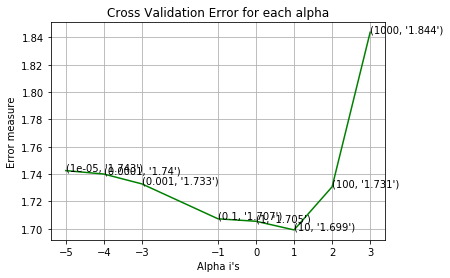

For values of best alpha =  10 The train log loss is: 1.344880392955681
For values of best alpha =  10 The cross validation log loss is: 1.6991350784981845
For values of best alpha =  10 The test log loss is: 1.7939306483374435
For values of best alpha =  10 The ratio of misclassified is: 67.92168674698796


In [117]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence = []
performence.append(["Naive Bayes", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on response coding data and with no class balancing

for alpha = 1e-05
Log Loss : 1.7526880258189441
for alpha = 0.0001
Log Loss : 1.745876088896073
for alpha = 0.001
Log Loss : 1.7409697334173753
for alpha = 0.1
Log Loss : 1.7108313551391134
for alpha = 1
Log Loss : 1.7133962758715668
for alpha = 10
Log Loss : 1.7688775650834458
for alpha = 100
Log Loss : 1.793578709187061
for alpha = 1000
Log Loss : 2.3073269710314763


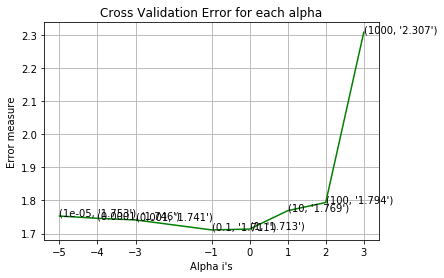

For values of best alpha =  0.1 The train log loss is: 1.3408270743761015
For values of best alpha =  0.1 The cross validation log loss is: 1.7108313551391134
For values of best alpha =  0.1 The test log loss is: 1.7860027535726546
For values of best alpha =  0.1 The ratio of misclassified is: 66.71686746987952


In [118]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Naive Bayes", "Responce", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

## K Nearest Neighbour Classification

### Training on one hot data and with no class balancing

for number of neighbors = 5
Log Loss : 1.940348963760652
for number of neighbors = 11
Log Loss : 1.919538675084078
for number of neighbors = 15
Log Loss : 1.8737130365850838
for number of neighbors = 21
Log Loss : 1.8528425333656977
for number of neighbors = 31
Log Loss : 1.8253708631738925
for number of neighbors = 41
Log Loss : 1.8148951231873744
for number of neighbors = 51
Log Loss : 1.799559750232164
for number of neighbors = 99
Log Loss : 1.8030304038808385


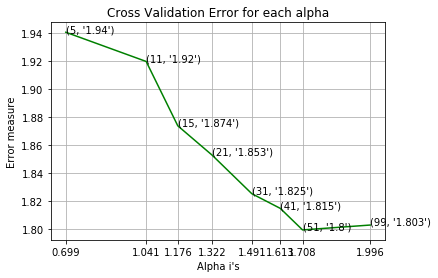

For values of best alpha =  51 The train log loss is: 1.3310928963259914
For values of best alpha =  51 The cross validation log loss is: 1.799559750232164
For values of best alpha =  51 The test log loss is: 1.902407012463091
For values of best alpha =  51 The ratio of misclassified is: 75.90361445783132


In [119]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier


alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for number of neighbors =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["KNN Classifier", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on response coding data and with no class balancing

for number of neighbors = 5
Log Loss : 1.9523499618924556
for number of neighbors = 11
Log Loss : 1.9203933798326682
for number of neighbors = 15
Log Loss : 1.875712694382645
for number of neighbors = 21
Log Loss : 1.8543191436480075
for number of neighbors = 31
Log Loss : 1.8262757728830608
for number of neighbors = 41
Log Loss : 1.8153907440513752
for number of neighbors = 51
Log Loss : 1.800368419267511
for number of neighbors = 99
Log Loss : 1.8031520204659441


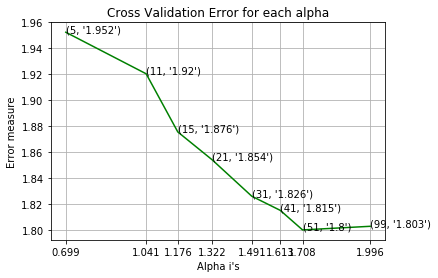

For values of best alpha =  51 The train log loss is: 1.3263640924271547
For values of best alpha =  51 The cross validation log loss is: 1.800368419267511
For values of best alpha =  51 The test log loss is: 1.9040417223530235
For values of best alpha =  51 The ratio of misclassified is: 76.20481927710844


In [120]:
# hyper parameter tuning

alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for number of neighbors =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["KNNClassifier", "Responce", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

## Logistic Regression

### Training on one hot data and with class balancing

for alpha = 1e-06
Log Loss : 1.8315841517469778
for alpha = 1e-05
Log Loss : 1.8315841517469778
for alpha = 0.0001
Log Loss : 1.8031603232709421
for alpha = 0.001
Log Loss : 1.7750721362151332
for alpha = 0.01
Log Loss : 1.7880023059911347
for alpha = 0.1
Log Loss : 1.8200734881816318
for alpha = 1
Log Loss : 1.8070861315355746
for alpha = 10
Log Loss : 1.7581107676567655
for alpha = 100
Log Loss : 1.7167408816915897


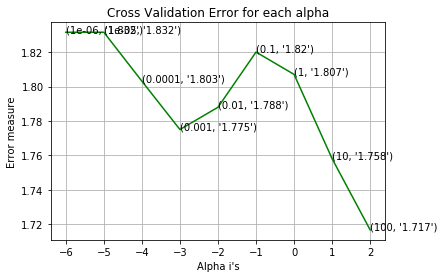

For values of best alpha =  100 The train log loss is: 1.2368418420155556
For values of best alpha =  100 The cross validation log loss is: 1.720916947867349
For values of best alpha =  100 The test log loss is: 1.7575593627468507
For values of best alpha =  100 The ratio of misclassified is: 67.92168674698796


In [121]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log')
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["SGD Classifier", "One hot", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on one hot data and with no class balancing

for alpha = 1e-06
Log Loss : 1.8378362209920318
for alpha = 1e-05
Log Loss : 1.8315393260585444
for alpha = 0.0001
Log Loss : 1.833517883421262
for alpha = 0.001
Log Loss : 1.810474743799903
for alpha = 0.01
Log Loss : 1.799815674957714
for alpha = 0.1
Log Loss : 1.790663858813302
for alpha = 1
Log Loss : 1.802496895137203
for alpha = 10
Log Loss : 1.777922095963654
for alpha = 100
Log Loss : 1.7308045291352643


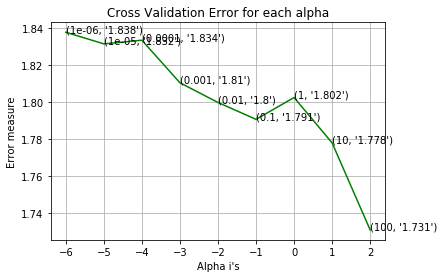

For values of best alpha =  100 The train log loss is: 1.227669642546957
For values of best alpha =  100 The cross validation log loss is: 1.7295514630131266
For values of best alpha =  100 The test log loss is: 1.7837541719546277
For values of best alpha =  100 The ratio of misclassified is: 67.46987951807229


In [122]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log')
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["SGD Classifier", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and with class balancing

for alpha = 1e-06
Log Loss : 1.8315841517469778
for alpha = 1e-05
Log Loss : 1.818632165624687
for alpha = 0.0001
Log Loss : 1.7928422232180146
for alpha = 0.001
Log Loss : 1.802156950666946
for alpha = 0.01
Log Loss : 1.8246585936001327
for alpha = 0.1
Log Loss : 1.8404109803380049
for alpha = 1
Log Loss : 1.8012979941870937
for alpha = 10
Log Loss : 1.7551613832115354
for alpha = 100
Log Loss : 1.7166338611341494


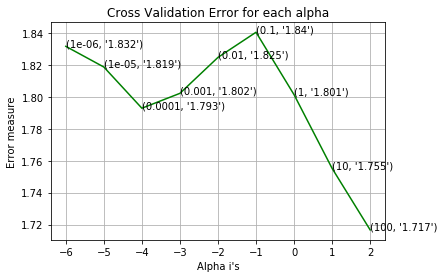

For values of best alpha =  100 The train log loss is: 1.235938572085999
For values of best alpha =  100 The cross validation log loss is: 1.7184685716795438
For values of best alpha =  100 The test log loss is: 1.7550707687183214
For values of best alpha =  100 The ratio of misclassified is: 67.62048192771084


In [123]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log')
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["SGD Classifier", "Response", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and no with class balancing

for alpha = 1e-06
Log Loss : 1.8315841517469778
for alpha = 1e-05
Log Loss : 1.8222031584036753
for alpha = 0.0001
Log Loss : 1.8052273323275034
for alpha = 0.001
Log Loss : 1.7902426739960602
for alpha = 0.01
Log Loss : 1.7950121997096065
for alpha = 0.1
Log Loss : 1.832488331228062
for alpha = 1
Log Loss : 1.7938109951932761
for alpha = 10
Log Loss : 1.7803569852612366
for alpha = 100
Log Loss : 1.7343503370743658


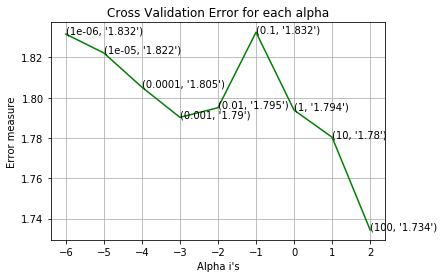

For values of best alpha =  100 The train log loss is: 1.2176974971941876
For values of best alpha =  100 The cross validation log loss is: 1.7338227690973853
For values of best alpha =  100 The test log loss is: 1.7868499150162032
For values of best alpha =  100 The ratio of misclassified is: 67.31927710843374


In [124]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log')
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["SGD Classifier", "Response", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

## Linear Support Vector Machines

### Training on one hot data and with class balancing

for alpha = 1e-06
Log Loss : 1.8315841517469778
for alpha = 1e-05
Log Loss : 1.8315841517469778
for alpha = 0.0001
Log Loss : 1.8047870071771548
for alpha = 0.001
Log Loss : 1.8044879280881152
for alpha = 0.01
Log Loss : 1.80280359359632
for alpha = 0.1
Log Loss : 1.790049600216373
for alpha = 1
Log Loss : 1.8266364473738526
for alpha = 10
Log Loss : 1.7654110832847025
for alpha = 100
Log Loss : 1.7477592285137404


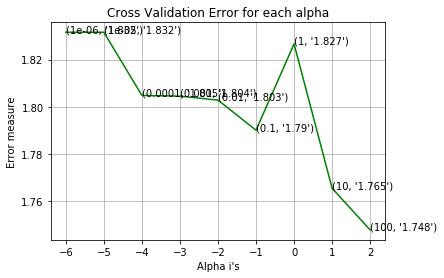

For values of best alpha =  100 The train log loss is: 1.252761774295515
For values of best alpha =  100 The cross validation log loss is: 1.7399913398867266
For values of best alpha =  100 The test log loss is: 1.7764569337027987
For values of best alpha =  100 The ratio of misclassified is: 70.18072289156626


In [125]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge')
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge')
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Linear SVM", "One hot", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on one hot data and with no class balancing

for alpha = 1e-06
Log Loss : 1.8315841517469778
for alpha = 1e-05
Log Loss : 1.8247181797849479
for alpha = 0.0001
Log Loss : 1.8102662472270434
for alpha = 0.001
Log Loss : 1.798582251126089
for alpha = 0.01
Log Loss : 1.798099714216616
for alpha = 0.1
Log Loss : 1.803251142742449
for alpha = 1
Log Loss : 1.8077671472968126
for alpha = 10
Log Loss : 1.8037321006637754
for alpha = 100
Log Loss : 1.7381475013000747


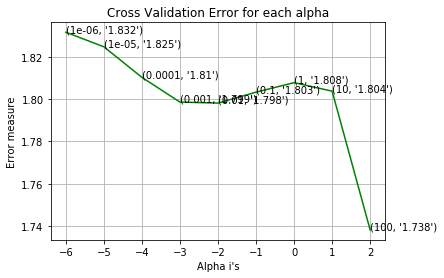

For values of best alpha =  100 The train log loss is: 1.2064603703694452
For values of best alpha =  100 The cross validation log loss is: 1.7376699805106746
For values of best alpha =  100 The test log loss is: 1.8061854363212309
For values of best alpha =  100 The ratio of misclassified is: 69.7289156626506


In [126]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge')
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge')
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Linear SVM", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and with class balancing

for alpha = 1e-06
Log Loss : 1.8315841517469778
for alpha = 1e-05
Log Loss : 1.830526379631276
for alpha = 0.0001
Log Loss : 1.8385000932928712
for alpha = 0.001
Log Loss : 1.8080318131835418
for alpha = 0.01
Log Loss : 1.795073766321523
for alpha = 0.1
Log Loss : 1.81893317736578
for alpha = 1
Log Loss : 1.7852631280973983
for alpha = 10
Log Loss : 1.7925357368419343
for alpha = 100
Log Loss : 1.74038605407236


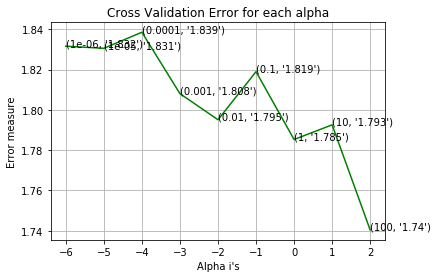

For values of best alpha =  100 The train log loss is: 1.2681939971666416
For values of best alpha =  100 The cross validation log loss is: 1.7431875024292378
For values of best alpha =  100 The test log loss is: 1.7792759675098724
For values of best alpha =  100 The ratio of misclassified is: 70.03012048192771


In [127]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge')
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge')
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Linear SVM", "Response", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and no with class balancing

for alpha = 1e-06
Log Loss : 1.8315841517469778
for alpha = 1e-05
Log Loss : 1.8209800934960994
for alpha = 0.0001
Log Loss : 1.8297945974786942
for alpha = 0.001
Log Loss : 1.8016736641070958
for alpha = 0.01
Log Loss : 1.7794264206368373
for alpha = 0.1
Log Loss : 1.805744662939274
for alpha = 1
Log Loss : 1.7854637094273818
for alpha = 10
Log Loss : 1.7761791317270557
for alpha = 100
Log Loss : 1.7367883139696108


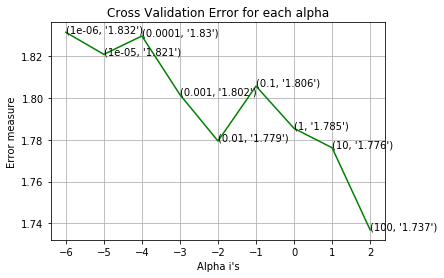

For values of best alpha =  100 The train log loss is: 1.2079313812999555
For values of best alpha =  100 The cross validation log loss is: 1.7434638639990774
For values of best alpha =  100 The test log loss is: 1.8075788854394683
For values of best alpha =  100 The ratio of misclassified is: 70.63253012048193


In [128]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge')
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge')
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Linear SVM", "Response", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

##  Random Forest Classifier

### Training on one hot data and with no class balancing

In [129]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier


alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, n_jobs=3)
        clf.fit(one_hot_Train, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(one_hot_Train, train_y)
        sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        # to avoid rounding error while multiplying probabilites we use log-probability estimates
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', 
                             max_depth=max_depth[int(best_alpha%2)], n_jobs=3)

clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Random Forest", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

for n_estimators = 100 and max depth =  5
Log Loss : 1.6162714221744592
for n_estimators = 100 and max depth =  10
Log Loss : 1.6752061234063589
for n_estimators = 200 and max depth =  5
Log Loss : 1.5992621865508672
for n_estimators = 200 and max depth =  10
Log Loss : 1.6690859420733428
for n_estimators = 500 and max depth =  5
Log Loss : 1.5857164790227094
for n_estimators = 500 and max depth =  10
Log Loss : 1.645181545733576
for n_estimators = 1000 and max depth =  5
Log Loss : 1.5809606451698177
for n_estimators = 1000 and max depth =  10
Log Loss : 1.6589671523064973
for n_estimators = 2000 and max depth =  5
Log Loss : 1.585061133274361
for n_estimators = 2000 and max depth =  10
Log Loss : 1.6545942729014143
For values of best alpha =  1000 The train log loss is: 0.9014629163551748
For values of best alpha =  1000 The cross validation log loss is: 1.5707855795854022
For values of best alpha =  1000 The test log loss is: 1.7158303927185456
For values of best alpha =  1000 The r

### Training on responce coding data and no with class balancing

In [130]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier


alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, n_jobs=3)
        clf.fit(responseCoding_Train, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(responseCoding_Train, train_y)
        sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        # to avoid rounding error while multiplying probabilites we use log-probability estimates
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', 
                             max_depth=max_depth[int(best_alpha%2)], n_jobs=3)

clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Random Forest", "Response", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

for n_estimators = 100 and max depth =  5
Log Loss : 1.3305428750387982
for n_estimators = 100 and max depth =  10
Log Loss : 1.4055710366259322
for n_estimators = 200 and max depth =  5
Log Loss : 1.3615459771340022
for n_estimators = 200 and max depth =  10
Log Loss : 1.3417981956773106
for n_estimators = 500 and max depth =  5
Log Loss : 1.32488612276726
for n_estimators = 500 and max depth =  10
Log Loss : 1.392388511082818
for n_estimators = 1000 and max depth =  5
Log Loss : 1.3528435019639573
for n_estimators = 1000 and max depth =  10
Log Loss : 1.4054941641913028
for n_estimators = 2000 and max depth =  5
Log Loss : 1.3416987865553203
for n_estimators = 2000 and max depth =  10
Log Loss : 1.4040333665815445
For values of best alpha =  500 The train log loss is: 0.22538783670121834
For values of best alpha =  500 The cross validation log loss is: 1.3698738972764077
For values of best alpha =  500 The test log loss is: 1.5466959577518438
For values of best alpha =  500 The ratio

## Decision Tree

### Training on one hot data and with class balancing

For max depth =  100
Log Loss : 1.8758069537237514
For max depth =  300
Log Loss : 1.8937236882430672
For max depth =  500
Log Loss : 1.8745298739049403
For max depth =  800
Log Loss : 1.8477196804922311
For max depth =  1000
Log Loss : 1.888155663262002
For max depth =  1500
Log Loss : 1.893752139534769
For max depth =  2000
Log Loss : 1.8829832353469578


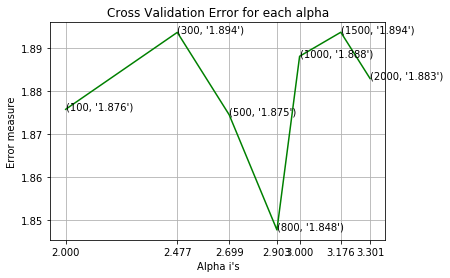

For values of best alpha =  800 The train log loss is: 0.7885545364367363
For values of best alpha =  800 The cross validation log loss is: 1.855221961089971
For values of best alpha =  800 The test log loss is: 1.9283148749290655
For values of best alpha =  800 The ratio of misclassified is: 77.86144578313254


In [131]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier


alpha = [100, 300, 500, 800, 1000, 1500, 2000]
cv_log_error_array = []
for j in alpha:
    print("For max depth = ", j)
    clf = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=j)
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = DecisionTreeClassifier(class_weight='balanced', criterion='gini', 
                             max_depth=alpha[best_alpha])

clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Decision Tree", "One hot", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on one hot data and with no class balancing

For max depth =  100
Log Loss : 1.8625548833945065
For max depth =  300
Log Loss : 1.9116758273144927
For max depth =  500
Log Loss : 1.8397243424075078
For max depth =  800
Log Loss : 1.8754554639484395
For max depth =  1000
Log Loss : 1.8385342233778559
For max depth =  1500
Log Loss : 1.8765306624045621
For max depth =  2000
Log Loss : 1.900767726816484


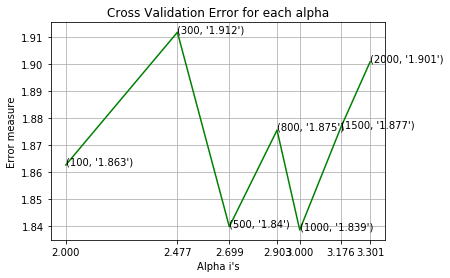

For values of best alpha =  1000 The train log loss is: 0.751180255850264
For values of best alpha =  1000 The cross validation log loss is: 1.876279947091307
For values of best alpha =  1000 The test log loss is: 1.9719780032001748
For values of best alpha =  1000 The ratio of misclassified is: 78.16265060240963


In [132]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier


max_depth = [100, 300, 500, 800, 1000, 1500, 2000]
cv_log_error_array = []
for j in max_depth:
    print("For max depth = ", j)
    clf = DecisionTreeClassifier(criterion='gini', max_depth=j)
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = DecisionTreeClassifier(criterion='gini', 
                             max_depth=alpha[best_alpha])

clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Decision Tree", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and with class balancing

For max depth =  100
Log Loss : 2.9394185530299075
For max depth =  300
Log Loss : 2.9200838676641943
For max depth =  500
Log Loss : 2.9334249309329636
For max depth =  800
Log Loss : 2.9920068180314643
For max depth =  1000
Log Loss : 2.978922462030874
For max depth =  1500
Log Loss : 2.9120781168952377
For max depth =  2000
Log Loss : 2.939742166740789


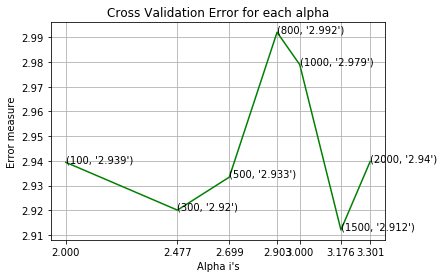

For values of best alpha =  1500 The train log loss is: 0.05546122560736815
For values of best alpha =  1500 The cross validation log loss is: 3.0355259201745524
For values of best alpha =  1500 The test log loss is: 3.144074431202524
For values of best alpha =  1500 The ratio of misclassified is: 66.71686746987952


In [133]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier


alpha = [100, 300, 500, 800, 1000, 1500, 2000]
cv_log_error_array = []
for j in alpha:
    print("For max depth = ", j)
    clf = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=j)
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = DecisionTreeClassifier(class_weight='balanced', criterion='gini', 
                             max_depth=alpha[best_alpha])

clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Decision Tree", "response", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and no with class balancing

For max depth =  100
Log Loss : 4.501230803760788
For max depth =  300
Log Loss : 4.429941102606801
For max depth =  500
Log Loss : 4.42009180437085
For max depth =  800
Log Loss : 4.417539484347618
For max depth =  1000
Log Loss : 4.41059881597413
For max depth =  1500
Log Loss : 4.435938386805555
For max depth =  2000
Log Loss : 4.417081643362794


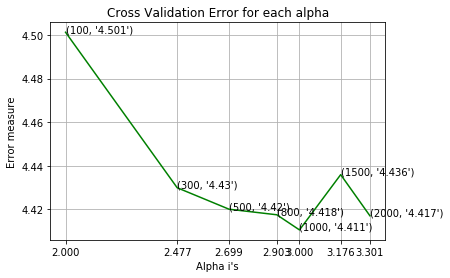

For values of best alpha =  1000 The train log loss is: 0.052786421698254385
For values of best alpha =  1000 The cross validation log loss is: 4.340361297279951
For values of best alpha =  1000 The test log loss is: 4.392923471975934
For values of best alpha =  1000 The ratio of misclassified is: 93.82530120481928


In [134]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier


alpha = [100, 300, 500, 800, 1000, 1500, 2000]
cv_log_error_array = []
for j in alpha:
    print("For max depth = ", j)
    clf = DecisionTreeClassifier(criterion='gini', max_depth=j)
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = DecisionTreeClassifier(criterion='gini', 
                             max_depth=alpha[best_alpha])

clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Decision Tree", "response", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

## Stack the models

### Training on one hot encoding with class balancing

In [135]:
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier

clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', 
                     class_weight='balanced', random_state=0)
clf1.fit(one_hot_Train, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', 
                     class_weight='balanced', random_state=0)
clf2.fit(one_hot_Train, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(one_hot_Train, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(one_hot_Train, train_y)
print("Logistic Regression :  Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf1.predict_proba(one_hot_Cv))))
sig_clf2.fit(one_hot_Train, train_y)
print("Support vector machines : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf2.predict_proba(one_hot_Cv))))
sig_clf3.fit(one_hot_Train, train_y)
print("Naive Bayes : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf3.predict_proba(one_hot_Cv))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                              meta_classifier=lr, use_probas=True)
    sclf.fit(one_hot_Train, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" 
          % (i, log_loss(cv_y, sclf.predict_proba(one_hot_Cv))))
    log_error =log_loss(cv_y, sclf.predict_proba(one_hot_Cv))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.84
Support vector machines : Log Loss: 1.82
Naive Bayes : Log Loss: 1.73
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.184
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.099
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.874
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.733
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.806
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.911


In [136]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                          meta_classifier=lr, use_probas=True)
sclf.fit(one_hot_Train, train_y)

te = []
predict_y = sclf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["SGD+SGD+NB", "one hot", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 1.1852796196281847
The cross validation log loss is: 1.7325301640277464
The test log loss is: 1.801046085882606
The ratio of misclassified is: 66.1144578313253


### Training on one hot encoding with no class balancing

In [137]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', 
                     random_state=0)
clf1.fit(one_hot_Train, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', 
                     random_state=0)
clf2.fit(one_hot_Train, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(one_hot_Train, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(one_hot_Train, train_y)
print("Logistic Regression :  Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf1.predict_proba(one_hot_Cv))))
sig_clf2.fit(one_hot_Train, train_y)
print("Support vector machines : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf2.predict_proba(one_hot_Cv))))
sig_clf3.fit(one_hot_Train, train_y)
print("Naive Bayes : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf3.predict_proba(one_hot_Cv))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                              meta_classifier=lr, use_probas=True)
    sclf.fit(one_hot_Train, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" 
          % (i, log_loss(cv_y, sclf.predict_proba(one_hot_Cv))))
    log_error =log_loss(cv_y, sclf.predict_proba(one_hot_Cv))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.83
Support vector machines : Log Loss: 1.83
Naive Bayes : Log Loss: 1.73
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.184
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.098
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.872
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.736
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.815
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.915


In [138]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                          meta_classifier=lr, use_probas=True)
sclf.fit(one_hot_Train, train_y)

te = []
predict_y = sclf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["SGD+SGD+NB", "one hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 1.1674246303474431
The cross validation log loss is: 1.736109603380652
The test log loss is: 1.7928740621655876
The ratio of misclassified is: 66.71686746987952


### Training on response coding with class balancing

In [139]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', 
                     class_weight='balanced', random_state=0)
clf1.fit(responseCoding_Train, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', 
                     class_weight='balanced', random_state=0)
clf2.fit(responseCoding_Train, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(responseCoding_Train, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(responseCoding_Train, train_y)
print("Logistic Regression :  Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf1.predict_proba(responseCoding_Cv))))
sig_clf2.fit(responseCoding_Train, train_y)
print("Support vector machines : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf2.predict_proba(responseCoding_Cv))))
sig_clf3.fit(responseCoding_Train, train_y)
print("Naive Bayes : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf3.predict_proba(responseCoding_Cv))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                              meta_classifier=lr, use_probas=True)
    sclf.fit(responseCoding_Train, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" 
          % (i, log_loss(cv_y, sclf.predict_proba(responseCoding_Cv))))
    log_error =log_loss(cv_y, sclf.predict_proba(responseCoding_Cv))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.83
Support vector machines : Log Loss: 1.82
Naive Bayes : Log Loss: 1.74
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.184
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.099
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.877
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.736
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.810
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.924


In [140]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                          meta_classifier=lr, use_probas=True)
sclf.fit(responseCoding_Train, train_y)

te = []
predict_y = sclf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["SGD+SGD+NB", "response", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 1.197721536625185
The cross validation log loss is: 1.7357687868218126
The test log loss is: 1.7997753907122072
The ratio of misclassified is: 66.41566265060241


### Training on response coding with no class balancing

In [141]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', 
                     random_state=0)
clf1.fit(responseCoding_Train, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', 
                     random_state=0)
clf2.fit(responseCoding_Train, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(responseCoding_Train, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(responseCoding_Train, train_y)
print("Logistic Regression :  Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf1.predict_proba(responseCoding_Cv))))
sig_clf2.fit(responseCoding_Train, train_y)
print("Support vector machines : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf2.predict_proba(responseCoding_Cv))))
sig_clf3.fit(responseCoding_Train, train_y)
print("Naive Bayes : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf3.predict_proba(responseCoding_Cv))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                              meta_classifier=lr, use_probas=True)
    sclf.fit(responseCoding_Train, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" 
          % (i, log_loss(cv_y, sclf.predict_proba(responseCoding_Cv))))
    log_error =log_loss(cv_y, sclf.predict_proba(responseCoding_Cv))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.83
Support vector machines : Log Loss: 1.82
Naive Bayes : Log Loss: 1.74
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.184
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.099
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.875
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.739
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.813
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.919


In [142]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                          meta_classifier=lr, use_probas=True)
sclf.fit(responseCoding_Train, train_y)

te = []
predict_y = sclf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["SGD+SGD+NB", "response", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 1.182487361332353
The cross validation log loss is: 1.7392869499774346
The test log loss is: 1.801826788237011
The ratio of misclassified is: 66.86746987951807


## Maximum voting Classifier

### Training on one hot encoding data with no class balancing

In [143]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], 
                        voting='soft')
sclf.fit(one_hot_Train, train_y)

te = []
predict_y = sclf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["Max Voting", "one hot", "No", round(te[0], 3),
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 1.1674246303474431
The cross validation log loss is: 1.736109603380652
The test log loss is: 1.7928740621655876
The ratio of misclassified is: 66.71686746987952


### Training on response coding data with no class balancing`

In [144]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], 
                        voting='soft')
sclf.fit(responseCoding_Train, train_y)

te = []
predict_y = sclf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["Max Voting", "response", "No", round(te[0], 3),
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 1.182487361332353
The cross validation log loss is: 1.7392869499774346
The test log loss is: 1.801826788237011
The ratio of misclassified is: 66.86746987951807


#  Bag of Words with tri-grams

## Featurize: Text
* Building countvectorizer by taking max 1500 feature.

In [146]:
from sklearn.feature_extraction.text import CountVectorizer

bow_model = CountVectorizer(ngram_range=(1,3), max_features=1500)
bow_Train = bow_model.fit_transform(train_x['TEXT'])
bow_Cv = bow_model.fit_transform(cv_x['TEXT'])
bow_Test = bow_model.fit_transform(test_x['TEXT'])

In [147]:
print("Structure of Text data: ")
print("Shape of bow train text: ", bow_Train.shape)
print("Shape of bow cv text: ", bow_Cv.shape)
print("Shape of bow test text: ", bow_Test.shape)

Structure of Text data: 
Shape of bow train text:  (2121, 1500)
Shape of bow cv text:  (531, 1500)
Shape of bow test text:  (664, 1500)


## Stacking features

In [148]:
from scipy.sparse import hstack

one_hot_Train = hstack((one_hot_geneTrain, one_hot_variationTrain, bow_Train))
one_hot_Cv = hstack((one_hot_geneCv, one_hot_variationCv, bow_Cv))
one_hot_Test = hstack((one_hot_geneTest, one_hot_variationTest, bow_Test))

In [149]:
print("Structure of Total one hot data: ")
print("Shape of one hot train data: ", one_hot_Train.shape)
print("Shape of one hot cv data: ", one_hot_Cv.shape)
print("Shape of one hot test data: ", one_hot_Test.shape)

Structure of Total one hot data: 
Shape of one hot train data:  (2121, 3695)
Shape of one hot cv data:  (531, 3695)
Shape of one hot test data:  (664, 3695)


In [150]:
from scipy.sparse import hstack

responseCoding_Train = hstack((responseCoding_geneTrain, responseCoding_variationTrain, bow_Train))
responseCoding_Cv = hstack((responseCoding_geneCv, responseCoding_variationCv, bow_Cv))
responseCoding_Test = hstack((responseCoding_geneTest, responseCoding_variationTest, bow_Test))

In [151]:
print("Structure of Total one hot data: ")
print("Shape of one hot train data: ", responseCoding_Train.shape)
print("Shape of one hot cv data: ", responseCoding_Cv.shape)
print("Shape of one hot test data: ", responseCoding_Test.shape)

Structure of Total one hot data: 
Shape of one hot train data:  (2121, 1518)
Shape of one hot cv data:  (531, 1518)
Shape of one hot test data:  (664, 1518)


# Machine Learning Models

## Naive Bayes

### Training on one hot data and with no class balancing

for alpha = 1e-05
Log Loss : 1.8515734672484452
for alpha = 0.0001
Log Loss : 1.853387207570379
for alpha = 0.001
Log Loss : 1.8439970248470543
for alpha = 0.1
Log Loss : 1.815029901310177
for alpha = 1
Log Loss : 1.8054317013147854
for alpha = 10
Log Loss : 1.7862016030899235
for alpha = 100
Log Loss : 1.7572521338885916
for alpha = 1000
Log Loss : 1.8285975349916226


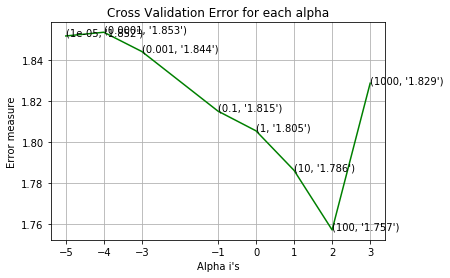

For values of best alpha =  100 The train log loss is: 1.4411191526350873
For values of best alpha =  100 The cross validation log loss is: 1.7572521338885916
For values of best alpha =  100 The test log loss is: 1.9807256814143448
For values of best alpha =  100 The ratio of misclassified is: 69.87951807228916


In [152]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence = []
performence.append(["Naive Bayes", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on response coding data and with no class balancing

for alpha = 1e-05
Log Loss : 1.8576780127549943
for alpha = 0.0001
Log Loss : 1.857137750019469
for alpha = 0.001
Log Loss : 1.8523313303819913
for alpha = 0.1
Log Loss : 1.8153106125245202
for alpha = 1
Log Loss : 1.807645340036571
for alpha = 10
Log Loss : 1.8243955571654225
for alpha = 100
Log Loss : 1.7994124169479944
for alpha = 1000
Log Loss : 2.202937829677916


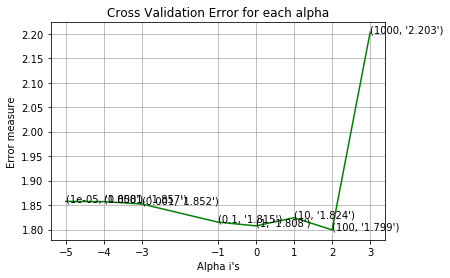

For values of best alpha =  100 The train log loss is: 1.3739461740142211
For values of best alpha =  100 The cross validation log loss is: 1.7994124169479944
For values of best alpha =  100 The test log loss is: 1.8438650905502394
For values of best alpha =  100 The ratio of misclassified is: 71.6867469879518


In [153]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Naive Bayes", "Responce", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

## K Nearest Neighbour Classification

### Training on one hot data and with no class balancing

for number of neighbors = 5
Log Loss : 1.9344149720323944
for number of neighbors = 11
Log Loss : 1.9137555048721402
for number of neighbors = 15
Log Loss : 1.9058833259419572
for number of neighbors = 21
Log Loss : 1.9047772431001706
for number of neighbors = 31
Log Loss : 1.889960096123227
for number of neighbors = 41
Log Loss : 1.8773234742527147
for number of neighbors = 51
Log Loss : 1.8737667962805526
for number of neighbors = 99
Log Loss : 1.8028242537759986


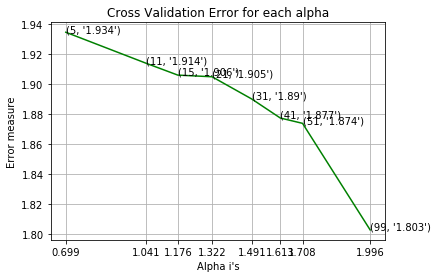

For values of best alpha =  99 The train log loss is: 1.4026438461536448
For values of best alpha =  99 The cross validation log loss is: 1.8028242537759986
For values of best alpha =  99 The test log loss is: 1.8538757437122368
For values of best alpha =  99 The ratio of misclassified is: 75.75301204819277


In [154]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier


alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for number of neighbors =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["KNN Classifier", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on response coding data and with no class balancing

for number of neighbors = 5
Log Loss : 1.9436553477583025
for number of neighbors = 11
Log Loss : 1.917551545616306
for number of neighbors = 15
Log Loss : 1.9081170697661967
for number of neighbors = 21
Log Loss : 1.9053154744254326
for number of neighbors = 31
Log Loss : 1.8900728330533476
for number of neighbors = 41
Log Loss : 1.879202269230107
for number of neighbors = 51
Log Loss : 1.8740355505069974
for number of neighbors = 99
Log Loss : 1.8027434349378932


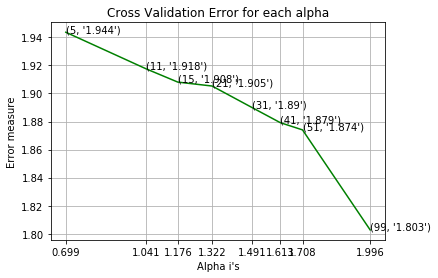

For values of best alpha =  99 The train log loss is: 1.4011127921311328
For values of best alpha =  99 The cross validation log loss is: 1.8027434349378932
For values of best alpha =  99 The test log loss is: 1.8536831635849316
For values of best alpha =  99 The ratio of misclassified is: 75.90361445783132


In [155]:
# hyper parameter tuning

alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for number of neighbors =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["KNNClassifier", "Responce", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

## Logistic Regression

### Training on one hot data and with class balancing

for alpha = 1e-06
Log Loss : 1.8315841517469778
for alpha = 1e-05
Log Loss : 1.8315841517469778
for alpha = 0.0001
Log Loss : 1.8796262499531788
for alpha = 0.001
Log Loss : 1.8847465960044596
for alpha = 0.01
Log Loss : 1.8945254781455891
for alpha = 0.1
Log Loss : 1.8602666755902175
for alpha = 1
Log Loss : 1.8651766042455864
for alpha = 10
Log Loss : 1.8340823700385038
for alpha = 100
Log Loss : 1.7680576018781866


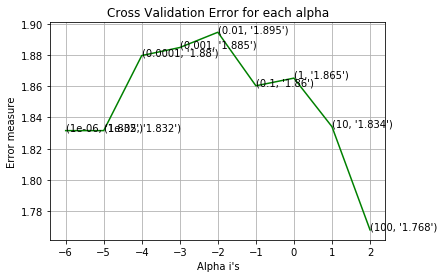

For values of best alpha =  100 The train log loss is: 1.2403135064703195
For values of best alpha =  100 The cross validation log loss is: 1.7690542695696503
For values of best alpha =  100 The test log loss is: 1.795509216794496
For values of best alpha =  100 The ratio of misclassified is: 70.78313253012048


In [156]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log')
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["SGD Classifier", "One hot", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on one hot data and with no class balancing

for alpha = 1e-06
Log Loss : 1.8315841517469778
for alpha = 1e-05
Log Loss : 1.8322328954485056
for alpha = 0.0001
Log Loss : 1.8980364536140357
for alpha = 0.001
Log Loss : 1.932870243526198
for alpha = 0.01
Log Loss : 1.9026651928151417
for alpha = 0.1
Log Loss : 1.9527897282403222
for alpha = 1
Log Loss : 1.9392517900674675
for alpha = 10
Log Loss : 1.8574124910216576
for alpha = 100
Log Loss : 1.7816837614768637


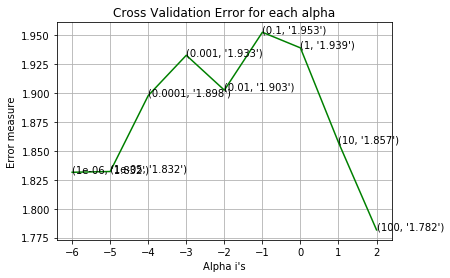

For values of best alpha =  100 The train log loss is: 1.2291470661428965
For values of best alpha =  100 The cross validation log loss is: 1.7785737118494418
For values of best alpha =  100 The test log loss is: 1.8245433392230679
For values of best alpha =  100 The ratio of misclassified is: 71.3855421686747


In [157]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log')
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["SGD Classifier", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and with class balancing

for alpha = 1e-06
Log Loss : 1.8315841517469778
for alpha = 1e-05
Log Loss : 1.8413222705069978
for alpha = 0.0001
Log Loss : 1.8666813121496597
for alpha = 0.001
Log Loss : 1.892235061399793
for alpha = 0.01
Log Loss : 1.8943884769393609
for alpha = 0.1
Log Loss : 1.8752173931400664
for alpha = 1
Log Loss : 1.9158420850028681
for alpha = 10
Log Loss : 1.8323813034730911
for alpha = 100
Log Loss : 1.7688822787778062


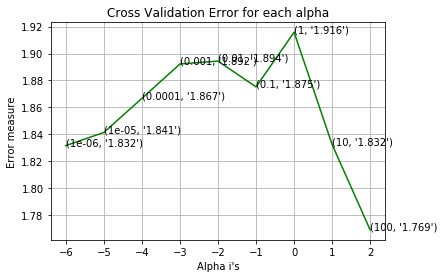

For values of best alpha =  100 The train log loss is: 1.238403061718361
For values of best alpha =  100 The cross validation log loss is: 1.7678940856299221
For values of best alpha =  100 The test log loss is: 1.7935132421405129
For values of best alpha =  100 The ratio of misclassified is: 70.78313253012048


In [158]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log')
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["SGD Classifier", "Response", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and no with class balancing

for alpha = 1e-06
Log Loss : 1.8315841517469778
for alpha = 1e-05
Log Loss : 1.8328995421823366
for alpha = 0.0001
Log Loss : 1.8756556802732791
for alpha = 0.001
Log Loss : 1.8907892575907297
for alpha = 0.01
Log Loss : 1.8983869360771461
for alpha = 0.1
Log Loss : 1.9188800267479045
for alpha = 1
Log Loss : 1.8792814800628848
for alpha = 10
Log Loss : 1.8613260716855353
for alpha = 100
Log Loss : 1.779954612642004


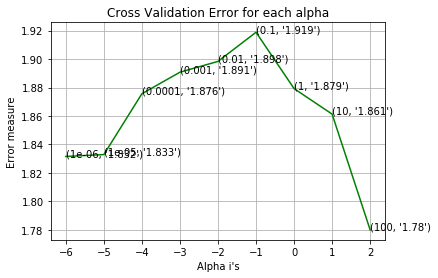

For values of best alpha =  100 The train log loss is: 1.226969670614995
For values of best alpha =  100 The cross validation log loss is: 1.7778131626303697
For values of best alpha =  100 The test log loss is: 1.8251928826338322
For values of best alpha =  100 The ratio of misclassified is: 71.53614457831326


In [159]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log')
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["SGD Classifier", "Response", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

## Linear Support Vector Machines

### Training on one hot data and with class balancing

for alpha = 1e-06
Log Loss : 1.8315841517469778
for alpha = 1e-05
Log Loss : 1.8315841517469778
for alpha = 0.0001
Log Loss : 1.9212043789357087
for alpha = 0.001
Log Loss : 1.8708765679034993
for alpha = 0.01
Log Loss : 1.8739883803340358
for alpha = 0.1
Log Loss : 1.8754093568581967
for alpha = 1
Log Loss : 1.8647543275608738
for alpha = 10
Log Loss : 1.8492220308812866
for alpha = 100
Log Loss : 1.7856206894294546


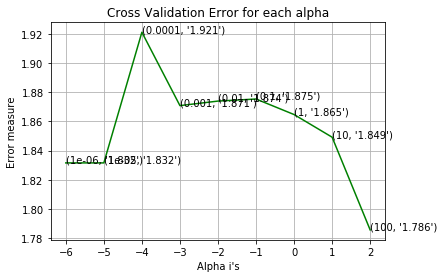

For values of best alpha =  100 The train log loss is: 1.2480000968160656
For values of best alpha =  100 The cross validation log loss is: 1.7858030724889116
For values of best alpha =  100 The test log loss is: 1.8089011724631285
For values of best alpha =  100 The ratio of misclassified is: 70.63253012048193


In [160]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge')
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge')
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Linear SVM", "One hot", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on one hot data and with no class balancing

for alpha = 1e-06
Log Loss : 1.8315841517469778
for alpha = 1e-05
Log Loss : 1.8344291523144927
for alpha = 0.0001
Log Loss : 1.8888849466829656
for alpha = 0.001
Log Loss : 1.8983126553957
for alpha = 0.01
Log Loss : 1.8700588561685094
for alpha = 0.1
Log Loss : 1.9159702337748827
for alpha = 1
Log Loss : 1.8751000592624913
for alpha = 10
Log Loss : 1.8858907268802465
for alpha = 100
Log Loss : 1.7917945318874735


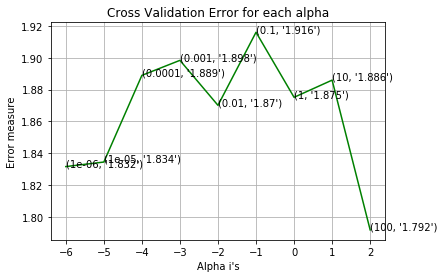

For values of best alpha =  100 The train log loss is: 1.2072819729740591
For values of best alpha =  100 The cross validation log loss is: 1.7881818657801283
For values of best alpha =  100 The test log loss is: 1.8295898429970667
For values of best alpha =  100 The ratio of misclassified is: 72.7409638554217


In [161]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge')
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge')
clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Linear SVM", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and with class balancing

for alpha = 1e-06
Log Loss : 1.8315841517469778
for alpha = 1e-05
Log Loss : 1.8257131849016384
for alpha = 0.0001
Log Loss : 1.8648239826898652
for alpha = 0.001
Log Loss : 1.8754910741282242
for alpha = 0.01
Log Loss : 1.8808779587888436
for alpha = 0.1
Log Loss : 1.8724715109221346
for alpha = 1
Log Loss : 1.8729793734651263
for alpha = 10
Log Loss : 1.8479444524372108
for alpha = 100
Log Loss : 1.7865576396862086


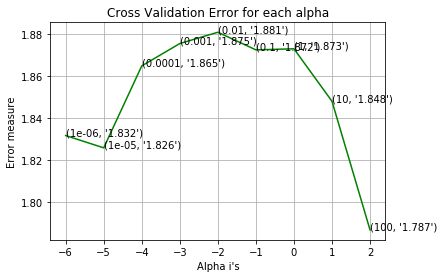

For values of best alpha =  100 The train log loss is: 1.2486379786905646
For values of best alpha =  100 The cross validation log loss is: 1.7812838410743126
For values of best alpha =  100 The test log loss is: 1.8069363079699683
For values of best alpha =  100 The ratio of misclassified is: 70.48192771084338


In [162]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge')
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge')
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Linear SVM", "Response", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and no with class balancing

for alpha = 1e-06
Log Loss : 1.8315841517469778
for alpha = 1e-05
Log Loss : 1.8297420367312733
for alpha = 0.0001
Log Loss : 1.8668661506128985
for alpha = 0.001
Log Loss : 1.8774088937721793
for alpha = 0.01
Log Loss : 1.8945795059439836
for alpha = 0.1
Log Loss : 1.9100393366820148
for alpha = 1
Log Loss : 1.8966894430388708
for alpha = 10
Log Loss : 1.8939283790858414
for alpha = 100
Log Loss : 1.7879750916996178


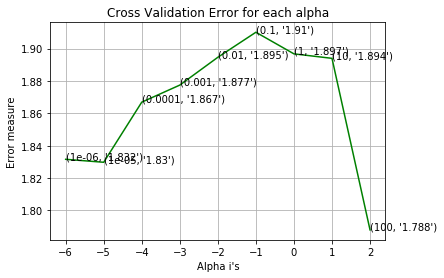

For values of best alpha =  100 The train log loss is: 1.2025412305896572
For values of best alpha =  100 The cross validation log loss is: 1.7924380146539742
For values of best alpha =  100 The test log loss is: 1.8331010597957371
For values of best alpha =  100 The ratio of misclassified is: 73.3433734939759


In [163]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge')
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge')
clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Linear SVM", "Response", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

##  Random Forest Classifier

### Training on one hot data and with no class balancing

In [164]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier


alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, n_jobs=3)
        clf.fit(one_hot_Train, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(one_hot_Train, train_y)
        sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        # to avoid rounding error while multiplying probabilites we use log-probability estimates
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', 
                             max_depth=max_depth[int(best_alpha%2)], n_jobs=3)

clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Random Forest", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

for n_estimators = 100 and max depth =  5
Log Loss : 1.6862385400420044
for n_estimators = 100 and max depth =  10
Log Loss : 1.7124467851141185
for n_estimators = 200 and max depth =  5
Log Loss : 1.6537306717733584
for n_estimators = 200 and max depth =  10
Log Loss : 1.7117730334420511
for n_estimators = 500 and max depth =  5
Log Loss : 1.6401952870529046
for n_estimators = 500 and max depth =  10
Log Loss : 1.7046213549057643
for n_estimators = 1000 and max depth =  5
Log Loss : 1.6389044647188074
for n_estimators = 1000 and max depth =  10
Log Loss : 1.6984908930373959
for n_estimators = 2000 and max depth =  5
Log Loss : 1.6388292049965378
for n_estimators = 2000 and max depth =  10
Log Loss : 1.7075947227248547
For values of best alpha =  2000 The train log loss is: 0.9027080905970966
For values of best alpha =  2000 The cross validation log loss is: 1.6445075354962684
For values of best alpha =  2000 The test log loss is: 1.7512309645153334
For values of best alpha =  2000 The

### Training on responce coding data and no with class balancing

In [165]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier


alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, n_jobs=3)
        clf.fit(responseCoding_Train, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(responseCoding_Train, train_y)
        sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        # to avoid rounding error while multiplying probabilites we use log-probability estimates
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', 
                             max_depth=max_depth[int(best_alpha%2)], n_jobs=3)

clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[int(best_alpha/2)], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Random Forest", "Response", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

for n_estimators = 100 and max depth =  5
Log Loss : 1.5964599610465715
for n_estimators = 100 and max depth =  10
Log Loss : 1.4764173675331733
for n_estimators = 200 and max depth =  5
Log Loss : 1.3806253575526033
for n_estimators = 200 and max depth =  10
Log Loss : 1.4619210698056684
for n_estimators = 500 and max depth =  5
Log Loss : 1.442071587857003
for n_estimators = 500 and max depth =  10
Log Loss : 1.5152276198041834
for n_estimators = 1000 and max depth =  5
Log Loss : 1.431789301740499
for n_estimators = 1000 and max depth =  10
Log Loss : 1.500804553029795
for n_estimators = 2000 and max depth =  5
Log Loss : 1.3962363401599627
for n_estimators = 2000 and max depth =  10
Log Loss : 1.511319161743875
For values of best alpha =  200 The train log loss is: 0.24188413180870583
For values of best alpha =  200 The cross validation log loss is: 1.3294367391735635
For values of best alpha =  200 The test log loss is: 1.5146668003895207
For values of best alpha =  200 The ratio 

## Decision Tree

### Training on one hot data and with class balancing

For max depth =  100
Log Loss : 1.8819734148743723
For max depth =  300
Log Loss : 1.9090264875498748
For max depth =  500
Log Loss : 1.9134903490482404
For max depth =  800
Log Loss : 1.8871827517523827
For max depth =  1000
Log Loss : 1.9145502766063764
For max depth =  1500
Log Loss : 1.9065788438182216
For max depth =  2000
Log Loss : 1.8702620139295598


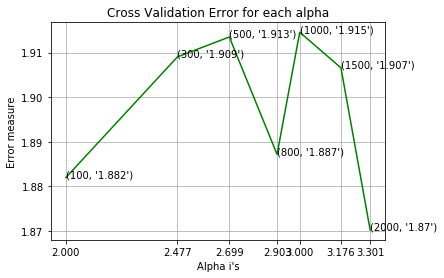

For values of best alpha =  2000 The train log loss is: 0.7736571125748332
For values of best alpha =  2000 The cross validation log loss is: 1.8606185415929706
For values of best alpha =  2000 The test log loss is: 1.9849265216679397
For values of best alpha =  2000 The ratio of misclassified is: 78.91566265060241


In [166]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier


alpha = [100, 300, 500, 800, 1000, 1500, 2000]
cv_log_error_array = []
for j in alpha:
    print("For max depth = ", j)
    clf = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=j)
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = DecisionTreeClassifier(class_weight='balanced', criterion='gini', 
                             max_depth=alpha[best_alpha])

clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Decision Tree", "One hot", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on one hot data and with no class balancing

For max depth =  100
Log Loss : 1.8941910577885606
For max depth =  300
Log Loss : 1.96672054338848
For max depth =  500
Log Loss : 1.9638667458553778
For max depth =  800
Log Loss : 1.9382206848285863
For max depth =  1000
Log Loss : 1.9528818981786722
For max depth =  1500
Log Loss : 1.9203175288501428
For max depth =  2000
Log Loss : 1.935582547537729


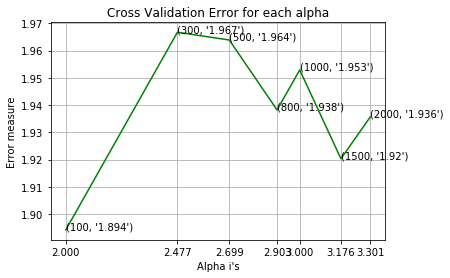

For values of best alpha =  100 The train log loss is: 0.7465161565777895
For values of best alpha =  100 The cross validation log loss is: 1.91474012075302
For values of best alpha =  100 The test log loss is: 1.9217062309130806
For values of best alpha =  100 The ratio of misclassified is: 78.46385542168674


In [167]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier


max_depth = [100, 300, 500, 800, 1000, 1500, 2000]
cv_log_error_array = []
for j in max_depth:
    print("For max depth = ", j)
    clf = DecisionTreeClassifier(criterion='gini', max_depth=j)
    clf.fit(one_hot_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(one_hot_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = DecisionTreeClassifier(criterion='gini', 
                             max_depth=alpha[best_alpha])

clf.fit(one_hot_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Decision Tree", "One hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and with class balancing

For max depth =  100
Log Loss : 3.014986980800771
For max depth =  300
Log Loss : 2.926377267139035
For max depth =  500
Log Loss : 2.9887417331353436
For max depth =  800
Log Loss : 2.9794331874366398
For max depth =  1000
Log Loss : 2.939589026361845
For max depth =  1500
Log Loss : 2.978256097829605
For max depth =  2000
Log Loss : 3.059845994518589


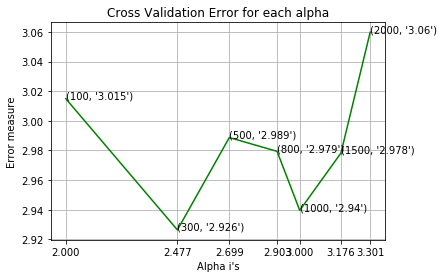

For values of best alpha =  300 The train log loss is: 0.060874869940922734
For values of best alpha =  300 The cross validation log loss is: 3.006234828066825
For values of best alpha =  300 The test log loss is: 3.0616528321613683
For values of best alpha =  300 The ratio of misclassified is: 68.52409638554217


In [168]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier


alpha = [100, 300, 500, 800, 1000, 1500, 2000]
cv_log_error_array = []
for j in alpha:
    print("For max depth = ", j)
    clf = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=j)
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = DecisionTreeClassifier(class_weight='balanced', criterion='gini', 
                             max_depth=alpha[best_alpha])

clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Decision Tree", "response", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

### Training on responce coding data and no with class balancing

For max depth =  100
Log Loss : 4.331684145621457
For max depth =  300
Log Loss : 4.3288953334297595
For max depth =  500
Log Loss : 4.328281140220501
For max depth =  800
Log Loss : 4.350136781095963
For max depth =  1000
Log Loss : 4.494111464119295
For max depth =  1500
Log Loss : 4.379515045472541
For max depth =  2000
Log Loss : 4.408922289675992


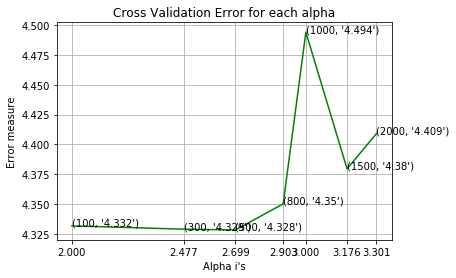

For values of best alpha =  500 The train log loss is: 0.05074318291546396
For values of best alpha =  500 The cross validation log loss is: 4.38766302936849
For values of best alpha =  500 The test log loss is: 4.423580248400701
For values of best alpha =  500 The ratio of misclassified is: 93.37349397590361


In [169]:
# hyper parameter tuning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier


alpha = [100, 300, 500, 800, 1000, 1500, 2000]
cv_log_error_array = []
for j in alpha:
    print("For max depth = ", j)
    clf = DecisionTreeClassifier(criterion='gini', max_depth=j)
    clf.fit(responseCoding_Train, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(responseCoding_Train, train_y)
    sig_clf_probs = sig_clf.predict_proba(responseCoding_Cv)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = DecisionTreeClassifier(criterion='gini', 
                             max_depth=alpha[best_alpha])

clf.fit(responseCoding_Train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(responseCoding_Train, train_y)

te = []
predict_y = sig_clf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The train log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The cross validation log loss is:", loss)

predict_y = sig_clf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print('For values of best alpha = ', alpha[best_alpha], 
      "The test log loss is:", loss)

mis_classified = np.count_nonzero((sig_clf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print('For values of best alpha = ', alpha[best_alpha], 
      "The ratio of misclassified is:", mis_classified)

performence.append(["Decision Tree", "response", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

## Stack the models

### Training on one hot encoding with class balancing

In [170]:
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier

clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', 
                     class_weight='balanced', random_state=0)
clf1.fit(one_hot_Train, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', 
                     class_weight='balanced', random_state=0)
clf2.fit(one_hot_Train, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(one_hot_Train, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(one_hot_Train, train_y)
print("Logistic Regression :  Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf1.predict_proba(one_hot_Cv))))
sig_clf2.fit(one_hot_Train, train_y)
print("Support vector machines : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf2.predict_proba(one_hot_Cv))))
sig_clf3.fit(one_hot_Train, train_y)
print("Naive Bayes : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf3.predict_proba(one_hot_Cv))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                              meta_classifier=lr, use_probas=True)
    sclf.fit(one_hot_Train, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" 
          % (i, log_loss(cv_y, sclf.predict_proba(one_hot_Cv))))
    log_error =log_loss(cv_y, sclf.predict_proba(one_hot_Cv))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.87
Support vector machines : Log Loss: 1.84
Naive Bayes : Log Loss: 1.84
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.184
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.102
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.892
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.807
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.980
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 2.140


In [171]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                          meta_classifier=lr, use_probas=True)
sclf.fit(one_hot_Train, train_y)

te = []
predict_y = sclf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["SGD+SGD+NB", "one hot", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 1.2109643295121746
The cross validation log loss is: 1.8072877444190008
The test log loss is: 1.8895560230004915
The ratio of misclassified is: 77.71084337349397


### Training on one hot encoding with no class balancing

In [172]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', 
                     random_state=0)
clf1.fit(one_hot_Train, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', 
                     random_state=0)
clf2.fit(one_hot_Train, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(one_hot_Train, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(one_hot_Train, train_y)
print("Logistic Regression :  Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf1.predict_proba(one_hot_Cv))))
sig_clf2.fit(one_hot_Train, train_y)
print("Support vector machines : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf2.predict_proba(one_hot_Cv))))
sig_clf3.fit(one_hot_Train, train_y)
print("Naive Bayes : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf3.predict_proba(one_hot_Cv))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                              meta_classifier=lr, use_probas=True)
    sclf.fit(one_hot_Train, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" 
          % (i, log_loss(cv_y, sclf.predict_proba(one_hot_Cv))))
    log_error =log_loss(cv_y, sclf.predict_proba(one_hot_Cv))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.89
Support vector machines : Log Loss: 1.88
Naive Bayes : Log Loss: 1.84
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.184
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.101
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.895
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.827
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.991
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 2.144


In [173]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                          meta_classifier=lr, use_probas=True)
sclf.fit(one_hot_Train, train_y)

te = []
predict_y = sclf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["SGD+SGD+NB", "one hot", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 1.1629459303286551
The cross validation log loss is: 1.826853344360962
The test log loss is: 1.8746101978057501
The ratio of misclassified is: 74.69879518072288


### Training on response coding with class balancing

In [174]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', 
                     class_weight='balanced', random_state=0)
clf1.fit(responseCoding_Train, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', 
                     class_weight='balanced', random_state=0)
clf2.fit(responseCoding_Train, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(responseCoding_Train, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(responseCoding_Train, train_y)
print("Logistic Regression :  Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf1.predict_proba(responseCoding_Cv))))
sig_clf2.fit(responseCoding_Train, train_y)
print("Support vector machines : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf2.predict_proba(responseCoding_Cv))))
sig_clf3.fit(responseCoding_Train, train_y)
print("Naive Bayes : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf3.predict_proba(responseCoding_Cv))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                              meta_classifier=lr, use_probas=True)
    sclf.fit(responseCoding_Train, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" 
          % (i, log_loss(cv_y, sclf.predict_proba(responseCoding_Cv))))
    log_error =log_loss(cv_y, sclf.predict_proba(responseCoding_Cv))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.87
Support vector machines : Log Loss: 1.85
Naive Bayes : Log Loss: 1.85
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.184
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.103
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.895
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.814
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.985
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 2.157


In [175]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                          meta_classifier=lr, use_probas=True)
sclf.fit(responseCoding_Train, train_y)

te = []
predict_y = sclf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["SGD+SGD+NB", "response", "Yes", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 1.2197655103059373
The cross validation log loss is: 1.8141936699572838
The test log loss is: 1.883909898321131
The ratio of misclassified is: 76.80722891566265


### Training on response coding with no class balancing

In [176]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', 
                     random_state=0)
clf1.fit(responseCoding_Train, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', 
                     random_state=0)
clf2.fit(responseCoding_Train, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(responseCoding_Train, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(responseCoding_Train, train_y)
print("Logistic Regression :  Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf1.predict_proba(responseCoding_Cv))))
sig_clf2.fit(responseCoding_Train, train_y)
print("Support vector machines : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf2.predict_proba(responseCoding_Cv))))
sig_clf3.fit(responseCoding_Train, train_y)
print("Naive Bayes : Log Loss: %0.2f" 
      % (log_loss(cv_y, sig_clf3.predict_proba(responseCoding_Cv))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                              meta_classifier=lr, use_probas=True)
    sclf.fit(responseCoding_Train, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" 
          % (i, log_loss(cv_y, sclf.predict_proba(responseCoding_Cv))))
    log_error =log_loss(cv_y, sclf.predict_proba(responseCoding_Cv))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.89
Support vector machines : Log Loss: 1.88
Naive Bayes : Log Loss: 1.85
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.184
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.102
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.896
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.829
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.996
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 2.159


In [177]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], 
                          meta_classifier=lr, use_probas=True)
sclf.fit(responseCoding_Train, train_y)

te = []
predict_y = sclf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["SGD+SGD+NB", "response", "No", round(te[0], 3), 
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 1.1698416515402865
The cross validation log loss is: 1.829155085990619
The test log loss is: 1.8741465516088094
The ratio of misclassified is: 74.69879518072288


## Maximum voting Classifier

### Training on one hot encoding data with no class balancing

In [178]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], 
                        voting='soft')
sclf.fit(one_hot_Train, train_y)

te = []
predict_y = sclf.predict_proba(one_hot_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(one_hot_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(one_hot_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["Max Voting", "one hot", "No", round(te[0], 3),
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 1.1629459303286551
The cross validation log loss is: 1.826853344360962
The test log loss is: 1.8746101978057501
The ratio of misclassified is: 74.69879518072288


### Training on response coding data with no class balancing`

In [179]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], 
                        voting='soft')
sclf.fit(responseCoding_Train, train_y)

te = []
predict_y = sclf.predict_proba(responseCoding_Train)
loss = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The train log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Cv)
loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The cross validation log loss is:", loss)

predict_y = sclf.predict_proba(responseCoding_Test)
loss = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
te.append(loss)
print("The test log loss is:", loss)

mis_classified = np.count_nonzero((sclf.predict(responseCoding_Test)- test_y))/test_y.shape[0] * 100
print("The ratio of misclassified is:", mis_classified)

performence.append(["Max Voting", "response", "No", round(te[0], 3),
                    round(te[1], 3), round(te[2], 3), round(mis_classified, 2)])

The train log loss is: 1.1698416515402865
The cross validation log loss is: 1.829155085990619
The test log loss is: 1.8741465516088094
The ratio of misclassified is: 74.69879518072288


# Conclusion

In [70]:
from prettytable import PrettyTable

tb = PrettyTable()
tb.field_names = ['Model', 'Featurization', 'Class Balanced', 'Train loss', 'Cv loss', 'Test loss',
                 'Mis classified']
for row in performence:
    tb.add_row(row)

print("Bag of words performence: ")
print(tb)

Bag of words performence: 
+----------------+---------------+----------------+------------+---------+-----------+----------------+
|     Model      | Featurization | Class Balanced | Train loss | Cv loss | Test loss | Mis classified |
+----------------+---------------+----------------+------------+---------+-----------+----------------+
|  Naive Bayes   |    One hot    |       No       |   1.308    |  1.739  |    1.78   |     64.76      |
|  Naive Bayes   |    Responce   |       No       |   1.322    |  1.748  |   1.796   |     66.42      |
| KNN Classifier |    One hot    |       No       |   1.397    |  1.763  |   1.795   |      75.0      |
| KNN Classifier |    Responce   |       No       |   1.395    |  1.763  |   1.796   |     75.45      |
| SGD Classifier |    One hot    |      Yes       |   1.229    |  1.741  |   1.743   |     64.76      |
| SGD Classifier |    One hot    |       No       |   1.225    |  1.756  |   1.742   |     61.75      |
| SGD Classifier |    Response   |   

In [108]:
from prettytable import PrettyTable

tb = PrettyTable()
tb.field_names = ['Model', 'Featurization', 'Class Balanced', 'Train loss', 'Cv loss', 'Test loss',
                 'Mis classified']
for row in performence:
    tb.add_row(row)

print("Tfidf performence: ")
print(tb)

Tfidf performence: 
+----------------+---------------+----------------+------------+---------+-----------+----------------+
|     Model      | Featurization | Class Balanced | Train loss | Cv loss | Test loss | Mis classified |
+----------------+---------------+----------------+------------+---------+-----------+----------------+
|  Naive Bayes   |    One hot    |       No       |   0.704    |  1.304  |   1.272   |     40.96      |
|  Naive Bayes   |    Responce   |       No       |   1.105    |   1.67  |   1.654   |     60.09      |
| KNN Classifier |    One hot    |       No       |   0.998    |  1.311  |   1.273   |     46.23      |
| KNN Classifier |    Responce   |       No       |   1.238    |  1.514  |   1.466   |     52.11      |
| SGD Classifier |    One hot    |      Yes       |   0.706    |  1.304  |   1.268   |     44.58      |
| SGD Classifier |    One hot    |       No       |   0.719    |  1.334  |   1.298   |     44.28      |
| SGD Classifier |    Response   |      Yes 

In [145]:
from prettytable import PrettyTable

tb = PrettyTable()
tb.field_names = ['Model', 'Featurization', 'Class Balanced', 'Train loss', 'Cv loss', 'Test loss',
                 'Mis classified']
for row in performence:
    tb.add_row(row)

print("Bag of words with bi-grams performence: ")
print(tb)

Bag of words with bi-grams performence: 
+----------------+---------------+----------------+------------+---------+-----------+----------------+
|     Model      | Featurization | Class Balanced | Train loss | Cv loss | Test loss | Mis classified |
+----------------+---------------+----------------+------------+---------+-----------+----------------+
|  Naive Bayes   |    One hot    |       No       |   1.345    |  1.699  |   1.794   |     67.92      |
|  Naive Bayes   |    Responce   |       No       |   1.341    |  1.711  |   1.786   |     66.72      |
| KNN Classifier |    One hot    |       No       |   1.331    |   1.8   |   1.902   |      75.9      |
| KNNClassifier  |    Responce   |       No       |   1.326    |   1.8   |   1.904   |      76.2      |
| SGD Classifier |    One hot    |      Yes       |   1.237    |  1.721  |   1.758   |     67.92      |
| SGD Classifier |    One hot    |       No       |   1.228    |   1.73  |   1.784   |     67.47      |
| SGD Classifier |    R

In [180]:
from prettytable import PrettyTable

tb = PrettyTable()
tb.field_names = ['Model', 'Featurization', 'Class Balanced', 'Train loss', 'Cv loss', 'Test loss',
                 'Mis classified']
for row in performence:
    tb.add_row(row)

print("Bag of words with tri-grams performence: ")
print(tb)

Bag of words with tri-grams performence: 
+----------------+---------------+----------------+------------+---------+-----------+----------------+
|     Model      | Featurization | Class Balanced | Train loss | Cv loss | Test loss | Mis classified |
+----------------+---------------+----------------+------------+---------+-----------+----------------+
|  Naive Bayes   |    One hot    |       No       |   1.441    |  1.757  |   1.981   |     69.88      |
|  Naive Bayes   |    Responce   |       No       |   1.374    |  1.799  |   1.844   |     71.69      |
| KNN Classifier |    One hot    |       No       |   1.403    |  1.803  |   1.854   |     75.75      |
| KNNClassifier  |    Responce   |       No       |   1.401    |  1.803  |   1.854   |      75.9      |
| SGD Classifier |    One hot    |      Yes       |    1.24    |  1.769  |   1.796   |     70.78      |
| SGD Classifier |    One hot    |       No       |   1.229    |  1.779  |   1.825   |     71.39      |
| SGD Classifier |    

* Finally best model is SGDClassifier with log loss and class balancing.
* for this model got cv error 1.304 and test error 1.268.